This notebook is aimed at looked at the allele analysis output a bit more interms of what are the alleles. What is missing? What is the GO term enrichment in those if any? How much are effectors?....
The input is based on the following ideas:


the idea is to label alleles, non_allelic 'orthologs' singeltons, and single nuclear genes.
* alleles are bast on proteinortho -synteny flag
* non_allelic 'orthologs' are genes that cluster on the protein level but are not allelic
* singeltons are genes without ‘ortholog’ in the other haplotype
* single haplotype genes are genes that have no gene to genome blast hit e_value = 1e-2 and are not in a homozygous region.

Final analysis is based on Pst_104E_v12_missing_allele_QC_v03.ipynb and Pst_104E_v12_defining_alleles_v03.ipynb in folder 
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/allele_analysis/no_alleles_proteinortho_graph516_QC_Qcov80_PctID70_evalue01 and alleles_proteinortho_graph516


In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import os
import re
from Bio import SeqIO
from Bio import SeqUtils
import pysam
from Bio.SeqRecord import SeqRecord
from pybedtools import BedTool
import numpy as np
import pybedtools
import time
import matplotlib.pyplot as plt
import sys
import subprocess
import shutil
from Bio.Seq import Seq
import pysam
from Bio import SearchIO
import json
import glob
import scipy.stats as stats
import distance
import seaborn as sns

/home/benjamin/anaconda3/lib/python3.5/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


In [3]:
pwh_set = []
def pwh_filter (q_contig, pwh_set=pwh_set):
    '''Checks if contig belongs to the primary with haplotig set.'''
    if q_contig in pwh_set:
        return True
    else:
        return False

In [4]:
def on_primary_contig (q_contig):
    '''Quick function that checks if query is on primary contig or not'''
    if q_contig.startswith('hcontig'):
        return False
    elif q_contig.startswith('pcontig'):
        return True
    else:
        print('Contig annotation needs to start with hcontig or pcontig')

In [323]:
###make a function out of the 5' and 3' prime distance
def _5_to_3_df(ref_bed_fn, query_bed_fn, io=False ):
    """Takes two bed6 filenames and returns dataframe with 5' and 3' distances."""
    from pybedtools import BedTool
    ref = BedTool(ref_bed_fn)
    query = BedTool(query_bed_fn)

    sub_3 = ref.closest(query ,io=io,  N=True, iu=True, D='a' ).to_dataframe()
    sub_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, \
                 inplace=True)
    sub_5 = ref.closest(query,\
                                io=io,N=True, id=True, D='a' ).to_dataframe()
    sub_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

    #merging them
    sub_merged = sub_3.merge(sub_5, on=['query', 'contig'])

    #needs to be fixed to take boundaries into account
    #remove genes on the edges
    sub_merged = sub_merged [((sub_merged['5_target'] != '.') & (sub_merged['3_target'] != '.') )  ]
    sub_merged['5_distance'] = sub_merged['5_distance'].apply(lambda x: np.absolute(x))
    return sub_merged

In [325]:
#define a function that subsets a dataframe to the inner quantil residual columnwise
def quant_cut_df(dataframe):
    nn_df = dataframe.copy()
    iqr_df_low = nn_df.apply(lambda x: x.quantile(0.25) - 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
    iqr_df_low.name ='low'
    iqr_df_high = nn_df.apply(lambda x: x.quantile(0.75) + 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
    iqr_df_high.name = 'high'

    iqr_df = pd.concat([iqr_df_low, iqr_df_high], axis=1).T

    iqr_nn_df = nn_df.apply(lambda x: x[(x > iqr_df.loc['low', x.name]) & (x  < iqr_df.loc['high', x.name])], axis=0)
    return iqr_nn_df 


In [5]:
#Define the PATH
BASE_AA_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12'
BASE_A_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'
BLAST_RESULT_PATH = os.path.join(BASE_AA_PATH,'allele_analysis' )
ALLELE_PATH =os.path.join(BASE_AA_PATH ,'allele_analysis/alleles_proteinortho_graph516')
ALLELE_QC_PATH = os.path.join(BASE_AA_PATH, 'allele_analysis', \
                              'no_alleles_proteinortho_graph516_QC_Qcov80_PctID70_evalue01')
LIST_PATH = os.path.join(BASE_AA_PATH, 'enrichment_analysis', 'lists')
POST_ALLELE_PATH = os.path.join(BASE_AA_PATH, 'post_allele_analysis')
OUT_PATH = os.path.join(POST_ALLELE_PATH, 'proteinortho_graph516_QC_Qcov80_PctID70_evalue01')
if not os.path.exists(POST_ALLELE_PATH):
    os.mkdir(POST_ALLELE_PATH)
if not os.path.exists(OUT_PATH):
    os.mkdir(OUT_PATH)
ph_gene_fasta = os.path.join(BASE_A_PATH , 'Pst_104E_v12_ph_ctg.anno.gene.fa')
ph_cds_fasta = os.path.join(BASE_A_PATH, 'Pst_104E_v12_ph_ctg.anno.CDS.fa')
ph_protein_fasta = os.path.join(BASE_A_PATH, 'Pst_104E_v12_ph_ctg.anno.protein.fa')

In [6]:
#get all the alleles in as they are not filtered by QCov and PctID but simply taken straight from the 
# proteinortho
allele_header = ['p_gene', 'h_gene']
a_overlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_overlap_df['Linkage'] = 'h_contig_overlap'
a_no_roverlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.no_respective_h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_no_roverlap_df['Linkage'] = 'no_r_overlap'
a_no_soverlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.no_specific_h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_no_soverlap_df['Linkage'] = 'no_s_overlap'
allele_df = pd.concat([a_overlap_df, a_no_roverlap_df, a_no_soverlap_df], axis=0)

In [326]:
feature_fn_dict = {}
feature_fn_dict['genes'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_all.gene.bed' )
feature_fn_dict['effector'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_effector.gene.bed' )
feature_fn_dict['busco'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_busco.gene.bed' )
feature_fn_dict['haustoria'] = os.path.join(LIST_PATH, 'Pst_104E_v12_cluster_8.gene.bed' )
feature_fn_dict['no_be'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_non_busco_non_effector.gene.bed')
feature_fn_dict['no_effector'] =os.path.join(LIST_PATH, 'Pst_104E_v12_p_noeffector.gene.bed')
feature_fn_dict['no_busco'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_non_busco.gene.bed')
feature_fn_dict['TE_g400'] = os.path.join(LIST_PATH,\
                                'Pst_104E_v12_p_ctg.REPET.sorted.g400_superfamily.bed' )
feature_fn_dict['TE_g1000'] = os.path.join(LIST_PATH,\
                                'Pst_104E_v12_p_ctg.REPET.sorted.g1000_superfamily.bed' )
feature_bed_dict = {}
for key, value in feature_fn_dict.items():
    feature_bed_dict[key] = BedTool(value)

In [7]:
#copy over allele files to OUTPATH
os.chdir(ALLELE_PATH)
!cp Pst_104E_v12_p_ctg.h_contig_overlap.alleles {OUT_PATH}/.
!cp Pst_104E_v12_p_ctg.no_respective_h_contig_overlap.alleles {OUT_PATH}/.
!cp Pst_104E_v12_p_ctg.no_specific_h_contig_overlap.alleles {OUT_PATH}/. 
!cat Pst_104E_v12_p_ctg.h_contig_overlap.alleles Pst_104E_v12_p_ctg.no_respective_h_contig_overlap.alleles Pst_104E_v12_p_ctg.no_specific_h_contig_overlap.alleles > {OUT_PATH}/Pst_104E_v12_p_ctg.all.alleles

In [8]:
#get the blast dataframe and the QC dataframe
allele_blast_df = pd.read_csv(os.path.join(BLAST_RESULT_PATH, 'Pst_104E_v12_p_ctg.Pst_104E_v12_h_ctg.0.001.blastp.outfmt6.allele_analysis'), sep='\t')
allele_QC_df = pd.read_csv(os.path.join(ALLELE_QC_PATH, 'Pst_104E_v12_ph_ctg.no_alleles_QC.Qcov80.PctID70.df'), sep='\t')

/home/benjamin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
#now filter out all the genes that already have alleles based on the protein ortho results
#this does not care about the 'abirary' cut offs for coverage and PctID
allele_QC_df = pd.read_csv(os.path.join(ALLELE_QC_PATH, 'Pst_104E_v12_ph_ctg.no_alleles_QC.Qcov80.PctID70.df'), sep='\t')
allele_QC_df = allele_QC_df[~((allele_QC_df.Query.isin(allele_df.p_gene))|(allele_QC_df.Query.isin(allele_df.h_gene)))].copy()


/home/benjamin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
#quick check if all the numbers of genes add up
len(allele_df.p_gene.unique())+ len(allele_df.h_gene.unique())+len(allele_QC_df.Query.unique()) == 30249

True

In [11]:
#now write out all no_allele_orthologs
no_allele_orthologs_fn = os.path.join(OUT_PATH, 'Pst_104E_v12_ph_ctg.no_alleles_orthologs')
no_allele_orthologs = allele_QC_df[allele_QC_df.singeltons == False]["Query"].unique()
tmp_fh = open(no_allele_orthologs_fn, 'w')
for _id in allele_QC_df[allele_QC_df.singeltons == False]["Query"].unique():
    print(_id, file=tmp_fh)
tmp_fh.close()

In [12]:
#write out singeltons
singeltons_fh = os.path.join(OUT_PATH, 'Pst_104E_v12_ph_ctg.singletons')
singeltons = allele_QC_df[(allele_QC_df.singeltons == True) & (allele_QC_df.ph_p_homo_region != True)]["Query"].unique()
tmp_fh = open(singeltons_fh , 'w')
for _id in singeltons:
    print(_id, file=tmp_fh)
tmp_fh.close()

In [13]:
#write out loose singeltons. This includes all the genes that are singletons also those that 
#are unphased
loose_singeltons_fh = os.path.join(OUT_PATH, 'Pst_104E_v12_ph_ctg.loose_singletons')
loose_singeltons = allele_QC_df[(allele_QC_df.singeltons == True) ]["Query"].unique()
tmp_fh = open(loose_singeltons_fh , 'w')
for _id in loose_singeltons:
    print(_id, file=tmp_fh)
tmp_fh.close()

In [14]:
#write out single nuclear genes defined as having no genome blast, being not in homozygous regions,
#and being singeltons
shg_df = allele_QC_df[(allele_QC_df.singeltons == True) & (allele_QC_df.gene_on_genome_blast_hit != True)\
            &(allele_QC_df.ph_p_homo_region != True)].copy()
shg_fh = os.path.join(OUT_PATH, 'Pst_104E_v12_ph_ctg.single_haplotype_genes')
shg = shg_df.Query.unique()
tmp_fh = open(shg_fh, 'w')
for _id in shg:
    print(_id, file=tmp_fh)
tmp_fh.close()

In [15]:
#now read in some types of genes
gene_group_list = ['BUSCOS', 'EFFECTORS', 'HAUSTORIA', 'EFFECTORP']
p_gene_dict = {}
h_gene_dict = {}
p_gene_dict['BUSCOS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_busco.list')\
                                    , header=None)[0].tolist()
p_gene_dict['EFFECTORS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_effector.list')\
                                    , header=None)[0].tolist()
p_gene_dict['HAUSTORIA'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_cluster_8.list')\
                                    , header=None)[0].tolist()
p_gene_dict['EFFECTORP'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_effectorp.list')\
                                    , header=None)[0].tolist()
p_gene_dict['SIGNALP3'] = pd.read_csv(os.path.join(LIST_PATH, '..', 'pa_26062017',\
                            'Pst_104E_v12_p_ctg.SignalP3.tablist'), header=None, sep='\t')[0].tolist()

h_gene_dict['BUSCOS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_busco.list')\
                                    , header=None)[0].tolist()
h_gene_dict['EFFECTORS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_effector.list')\
                                    , header=None)[0].tolist()
h_gene_dict['HAUSTORIA'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_cluster_15.list')\
                                    , header=None)[0].tolist()
h_gene_dict['EFFECTORP'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_effectorp.list')\
                                    , header=None)[0].tolist()
h_gene_dict['SIGNALP3'] = pd.read_csv(os.path.join(LIST_PATH, '..', 'pa_26062017',\
                            'Pst_104E_v12_h_ctg.SignalP3.tablist'), header=None, sep='\t')[0].tolist()

#now get pwh and pwoh
pwh_list = pd.read_csv(os.path.join(BASE_A_PATH, 'Pst_104E_v12_pwh.txt')\
                                , header=None)[0].tolist()
pwoh_list = pd.read_csv(os.path.join(BASE_A_PATH, 'Pst_104E_v12_pwoh.txt')\
                                , header=None)[0].tolist()

In [ ]:
#now read in some types of genes
gene_group_list = ['BUSCOS', 'EFFECTORS', 'HAUSTORIA', 'EFFECTORP']
p_bed_dict = {}
h_bed_dict = {}
p_bed_dict['BUSCOS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_busco.list')\
                                    , header=None)[0].tolist()
p_bed_dict['EFFECTORS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_effector.list')\
                                    , header=None)[0].tolist()
p_bed_dict['HAUSTORIA'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_cluster_8.list')\
                                    , header=None)[0].tolist()
p_bed_dict['EFFECTORP'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_effectorp.list')\
                                    , header=None)[0].tolist()
p_gene_dict['SIGNALP3'] = pd.read_csv(os.path.join(LIST_PATH, '..', 'pa_26062017',\
                            'Pst_104E_v12_p_ctg.SignalP3.tablist'), header=None, sep='\t')[0].tolist()

h_gene_dict['BUSCOS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_busco.list')\
                                    , header=None)[0].tolist()
h_gene_dict['EFFECTORS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_effector.list')\
                                    , header=None)[0].tolist()
h_gene_dict['HAUSTORIA'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_cluster_15.list')\
                                    , header=None)[0].tolist()
h_gene_dict['EFFECTORP'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_effectorp.list')\
                                    , header=None)[0].tolist()
h_gene_dict['SIGNALP3'] = pd.read_csv(os.path.join(LIST_PATH, '..', 'pa_26062017',\
                            'Pst_104E_v12_h_ctg.SignalP3.tablist'), header=None, sep='\t')[0].tolist()


In [16]:
#cause we are a bit lazy an like notebooks here we go looking for stuff
os.chdir(BASE_A_PATH)
print("Effectors on pwh contigs")
!cat Pst_104E_v12_pwh.txt | xargs -I X grep -w 'X' {LIST_PATH}/Pst_104E_v12_p_effector.gene.gff3 | wc -l 

Effectors on pwh contigs
1523


In [17]:
print("Effectors on pwoh contigs")
!cat Pst_104E_v12_pwoh.txt | xargs -I X grep -w 'X' {LIST_PATH}/Pst_104E_v12_p_effector.gene.gff3 | wc -l 

Effectors on pwoh contigs
49


In [18]:
print("BUSCOS on pwoh contigs")
!cat Pst_104E_v12_pwoh.txt | xargs -I X grep -w 'X' {LIST_PATH}/Pst_104E_v12_p_busco.gene.gff3 | wc -l 

BUSCOS on pwoh contigs
49


In [19]:
print("BUSCOS on pwh contigs")
!cat Pst_104E_v12_pwh.txt | xargs -I X grep -w 'X' {LIST_PATH}/Pst_104E_v12_p_busco.gene.gff3 | wc -l 

BUSCOS on pwh contigs
1395


In [20]:
print("BUSCOS on hcontigs")
!wc -l {LIST_PATH}/Pst_104E_v12_h_busco.gene.gff3

BUSCOS on hcontigs
1293 /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists/Pst_104E_v12_h_busco.gene.gff3


In [21]:
#now see if there is an enrichment in GO terms associated with alleles
def orphan_analysis(_orphan_list):
    """
    This is a function that prints out the numbers of total genes and how many of those are
    buscos or effectors. The same for haplotigs, primary contigs with haplotigs, and 
    primary contigs without haplotigs.
    """
    orphan_effectors = 0
    orphan_effectors_h = 0
    orphan_effectors_pwh = 0
    orphan_effectors_pwoh =0
    orphan_busco = 0
    orphan_busco_h = 0
    orphan_busco_pwh = 0
    orphan_busco_pwoh = 0
    for x in _orphan_list:
        if x in p_gene_dict['BUSCOS']:
            contig = re.search(r'[hp][^.]*',x).group()
            if pwh_filter(contig, pwh_list) == True:
                orphan_busco_pwh += 1
            else:
                orphan_busco_pwoh += 1
        if x in h_gene_dict['BUSCOS']:
            orphan_busco_h += 1
        #now same for effectors    
        if x in p_gene_dict['EFFECTORS']:
            contig = re.search(r'[hp][^.]*',x).group()
            if pwh_filter(contig, pwh_list) == True:
                orphan_effectors_pwh += 1
            else:
                orphan_effectors_pwoh += 1
            
        if x in h_gene_dict['EFFECTORS']:
            orphan_effectors_h += 1      
    orphan_effectors = orphan_effectors_h + orphan_effectors_pwh + orphan_effectors_pwoh
    orphan_busco = orphan_busco_h +  orphan_busco_pwh +  orphan_busco_pwoh
    print('Out of %i genes we have %i buscos and %i effectors.'\
          %(len(_orphan_list), orphan_busco, orphan_effectors))
    print('On haplotigs. Out of %i genes we have %i buscos and %i effectors.'\
         %(len([x for x in _orphan_list if 'hcontig' in x]), orphan_busco_h, orphan_effectors_h))
    print('On pwh. Out of %i genes we have %i buscos and %i effectors.'\
         %([pwh_filter(re.search(r'[hp][^.]*',x).group(), pwh_list) for x in _orphan_list].count(True), orphan_busco_pwh, orphan_effectors_pwh))
    print('On pwoh. Out of %i genes we have %i buscos and %i effectors.'\
         %([pwh_filter(re.search(r'[hp][^.]*',x).group(), pwh_list) for x in _orphan_list if 'pcontig' in x].count(False), orphan_busco_pwoh, orphan_effectors_pwoh))

In [22]:
allele_QC_df.columns

Index(['Query', 'Target', 'PctID', 'AlnLgth', 'NumMis', 'NumGap', 'StartQuery',
       'StopQuery', 'StartTarget', 'StopTarget', 'e-value', 'BitScore',
       'QLgth', 'QCov', 'q_contig', 't_contig', 'q_contig == t_contig',
       'primary_contig', 'pwh_contig', 'gene_on_genome_blast_hit',
       'exn_asso_contig', 'exn_no_asso_contig', 'ph_p_homo_region',
       'singeltons', 'Pst_E104_v1_ph_ctg.freebayes_SNP',
       'Pst_E104_v1_ph_ctg.freebayes_SNP_#',
       'Pst_E104_v1_ph_ctg.freebayes_SNP_%', 'overlap_p_on_h_mapping'],
      dtype='object')

In [23]:
print("Number of genes without clear allele:")
len(singeltons)

Number of genes without clear allele:


7029

In [24]:
print("For single haplotype genes:")
orphan_analysis(shg)

For single haplotype genes:
Out of 1506 genes we have 125 buscos and 120 effectors.
On haplotigs. Out of 160 genes we have 6 buscos and 5 effectors.
On pwh. Out of 1149 genes we have 93 buscos and 98 effectors.
On pwoh. Out of 197 genes we have 26 buscos and 17 effectors.


In [25]:
print("For singletons:")
orphan_analysis(singeltons)

For singletons:
Out of 7029 genes we have 234 buscos and 453 effectors.
On haplotigs. Out of 2931 genes we have 57 buscos and 153 effectors.
On pwh. Out of 3700 genes we have 147 buscos and 270 effectors.
On pwoh. Out of 398 genes we have 30 buscos and 30 effectors.


In [26]:
print("For loose singletons:")
orphan_analysis(loose_singeltons)

For loose singletons:
Out of 7692 genes we have 297 buscos and 502 effectors.
On haplotigs. Out of 2931 genes we have 57 buscos and 153 effectors.
On pwh. Out of 4289 genes we have 205 buscos and 318 effectors.
On pwoh. Out of 472 genes we have 35 buscos and 31 effectors.


In [27]:
#set the coverage limits
QCov_limit = 80
PctID_limit = 70
#now get all the ids for which we have hits above the cut off and are singletons
tmp_df = allele_QC_df[allele_QC_df.Target != 'False'] #filter out no hits
tmp_df[['QCov', 'PctID']] = tmp_df[['QCov', 'PctID']].apply(pd.to_numeric) #make numeric
#get ids of stuff above the cut off
tmp_df_ids = tmp_df[(tmp_df.QCov >= QCov_limit) & (tmp_df.PctID >= PctID_limit)]['Query'].unique()
#filter those out and everything that is not a singleton
tmp_df = allele_QC_df[~((allele_QC_df.Query.isin(tmp_df_ids)) | (allele_QC_df.singeltons == False))].copy()

/home/benjamin/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Everything below is about singeltons that don't have a significant protein blast hit with considering the QCov and PctID limit set above

In [28]:
#now filter dataframe on different other issues
out_filter = (tmp_df.exn_asso_contig != True) & (tmp_df.exn_no_asso_contig != True) & \
            (tmp_df.ph_p_homo_region != True)
queries_out_filtered = tmp_df[out_filter]['Query'].unique()
#now see if there is an enrichment in GO terms associated with alleles
orphan_analysis(queries_out_filtered)
#now print this out again into the ALLELE_QC folder
fn_short = 'Pst_104E_v12_ph_ctg.no_alleles_postQC.PctID%i_QCov%i.no_exonerate' % (PctID_limit, QCov_limit)
fn_short_p = 'Pst_104E_v12_p_ctg.no_alleles_postQC.PctID%i_QCov%i.no_exonerate' % (PctID_limit, QCov_limit)
fn_short_h = 'Pst_104E_v12_h_ctg.no_alleles_postQC.PctID%i_QCov%i.no_exonerate' % (PctID_limit, QCov_limit)
fn = os.path.join(ALLELE_QC_PATH, fn_short)
fn_list_h = os.path.join(LIST_PATH, fn_short_h)
fn_list_p = os.path.join(LIST_PATH, fn_short_p)
fh_list_p = open(fn_list_p, 'w')
fh_list_h = open(fn_list_h, 'w')
fh = open(fn, 'w')
for gene in queries_out_filtered:
    if 'pcontig' in gene:
        print(gene, file=fh_list_p)
    if 'hcontig' in gene:
        print(gene, file=fh_list_h)
    print(gene, file=fh)
fh.close()
fh_list_p.close()
fh_list_h.close()

Out of 3191 genes we have 180 buscos and 207 effectors.
On haplotigs. Out of 942 genes we have 26 buscos and 34 effectors.
On pwh. Out of 1998 genes we have 126 buscos and 152 effectors.
On pwoh. Out of 251 genes we have 28 buscos and 21 effectors.


In [29]:
#now filter dataframe on different other issues
out_filter =  (tmp_df.ph_p_homo_region != True)
queries_out_filtered = tmp_df[out_filter]['Query'].unique()
#now see if there is an enrichment in GO terms associated with alleles
print('Singletons that have are phased but have no good blast hit above the threshold')
orphan_analysis(queries_out_filtered)
#now print this out again into the ALLELE_QC folder
fn_short = 'Pst_104E_v12_ph_ctg.no_alleles_postQC.PctID%i_QCov%i.no_homo' % (PctID_limit, QCov_limit)
fn_short_p = 'Pst_104E_v12_p_ctg.no_alleles_postQC.PctID%i_QCov%i.no_homo' % (PctID_limit, QCov_limit)
fn_short_h = 'Pst_104E_v12_h_ctg.no_alleles_postQC.PctID%i_QCov%i.no_homo' % (PctID_limit, QCov_limit)
fn = os.path.join(ALLELE_QC_PATH, fn_short)
fn_list_h = os.path.join(LIST_PATH, fn_short_h)
fn_list_p = os.path.join(LIST_PATH, fn_short_p)
fh_list_p = open(fn_list_p, 'w')
fh_list_h = open(fn_list_h, 'w')
fh = open(fn, 'w')
for gene in queries_out_filtered:
    if 'pcontig' in gene:
        print(gene, file=fh_list_p)
    if 'hcontig' in gene:
        print(gene, file=fh_list_h)
    print(gene, file=fh)
fh.close()
fh_list_p.close()
fh_list_h.close()

Singletons that have are phased but have no good blast hit above the threshold
Out of 3991 genes we have 190 buscos and 303 effectors.
On haplotigs. Out of 1335 genes we have 31 buscos and 83 effectors.
On pwh. Out of 2393 genes we have 131 buscos and 198 effectors.
On pwoh. Out of 263 genes we have 28 buscos and 22 effectors.


In [30]:
#now make new filter for the following
out_filter = (tmp_df.exn_asso_contig != True) & (tmp_df.exn_no_asso_contig != True) & \
            (tmp_df.ph_p_homo_region == True)
queries_out_filtered = tmp_df[out_filter]['Query'].unique()
#now see if there is an enrichment in GO terms associated with alleles
print("For unphased singletons that have no exonerate alignments:")
orphan_analysis(queries_out_filtered)

For unphased singletons that have no exonerate alignments:
Out of 534 genes we have 62 buscos and 44 effectors.
On haplotigs. Out of 0 genes we have 0 buscos and 0 effectors.
On pwh. Out of 474 genes we have 57 buscos and 43 effectors.
On pwoh. Out of 60 genes we have 5 buscos and 1 effectors.


In [31]:
#now make new filter for the following
out_filter = (tmp_df.ph_p_homo_region == True)
queries_out_filtered = tmp_df[out_filter]['Query'].unique()
#now see if there is an enrichment in GO terms associated with alleles
print("For unphased singletons:")
orphan_analysis(queries_out_filtered)

For unphased singletons:
Out of 550 genes we have 62 buscos and 45 effectors.
On haplotigs. Out of 0 genes we have 0 buscos and 0 effectors.
On pwh. Out of 488 genes we have 57 buscos and 44 effectors.
On pwoh. Out of 62 genes we have 5 buscos and 1 effectors.


In [32]:
#now make new filter for the following
out_filter = (tmp_df.ph_p_homo_region == True) 
queries_out_filtered = tmp_df[out_filter]['Query'].unique()
#now see if there is an enrichment in GO terms associated with alleles
orphan_analysis(queries_out_filtered)
#now print this out again into the ALLELE_QC folder
fn_short = 'Pst_104E_v12_ph_ctg.no_alleles_postQC.homozygous_coverage' 
fn = os.path.join(ALLELE_QC_PATH, fn_short)
fh = open(fn, 'w')
for gene in queries_out_filtered:
    print(gene, file=fh)
fh.close()


Out of 550 genes we have 62 buscos and 45 effectors.
On haplotigs. Out of 0 genes we have 0 buscos and 0 effectors.
On pwh. Out of 488 genes we have 57 buscos and 44 effectors.
On pwoh. Out of 62 genes we have 5 buscos and 1 effectors.


In [33]:
#now make new filter for the following
out_filter = (tmp_df.exn_asso_contig == True) | (tmp_df.exn_no_asso_contig == True) 
queries_out_filtered = tmp_df[out_filter]['Query'].unique()
print("Singletons with exonerate alignment") 
orphan_analysis(queries_out_filtered)
print("I guess this means that BUSCOs might get annotated a bit better than other genes\
 including effectors.")
#now print this out again into the ALLELE_QC folder
fn_short = 'Pst_104E_v12_ph_ctg.no_alleles_postQC.exonerate_hits' 
fn = os.path.join(ALLELE_QC_PATH, fn_short)
fh = open(fn, 'w')
for gene in queries_out_filtered:
    print(gene, file=fh)
fh.close()

Singletons with exonerate alignment
Out of 816 genes we have 10 buscos and 97 effectors.
On haplotigs. Out of 393 genes we have 5 buscos and 49 effectors.
On pwh. Out of 409 genes we have 5 buscos and 47 effectors.
On pwoh. Out of 14 genes we have 0 buscos and 1 effectors.
I guess this means that BUSCOs might get annotated a bit better than other genes including effectors.


In [34]:
#now see if there is an enrichment in GO terms associated with alleles
#now make new filter for the following
out_filter = (tmp_df.exn_asso_contig == True) | (tmp_df.exn_no_asso_contig == True) & \
            (tmp_df.ph_p_homo_region != True)
queries_out_filtered = tmp_df[out_filter]['Query'].unique()
#now see if there is an enrichment in GO terms associated with alleles
orphan_analysis(queries_out_filtered)

Out of 809 genes we have 10 buscos and 96 effectors.
On haplotigs. Out of 393 genes we have 5 buscos and 49 effectors.
On pwh. Out of 404 genes we have 5 buscos and 46 effectors.
On pwoh. Out of 12 genes we have 0 buscos and 1 effectors.


In [35]:
#now make new filter for the following
out_filter = (allele_QC_df.exn_asso_contig == True) | (allele_QC_df.exn_no_asso_contig == True)\
    & (allele_QC_df.singeltons == True)
queries_out_filtered = allele_QC_df[out_filter]['Query'].unique()
print("For all singletons without filtering for Cov or PctID that have an exonerate alignment:")
orphan_analysis(queries_out_filtered)
print('Again we ')

For all singletons without filtering for Cov or PctID that have an exonerate alignment:
Out of 2531 genes we have 56 buscos and 230 effectors.
On haplotigs. Out of 1381 genes we have 32 buscos and 123 effectors.
On pwh. Out of 1097 genes we have 24 buscos and 102 effectors.
On pwoh. Out of 53 genes we have 0 buscos and 5 effectors.
Again we 


Look at some features of the orphan genes such as:
* gene/protein length
* gc content
* numbers of exons
* distance to TEs?

In [37]:
#now look at single haplotype genes
shg_df.drop_duplicates('Query')['QLgth'].mean()

349.0830013280212

In [38]:
allele_blast_df.drop_duplicates('Query')['QLgth'].mean()

394.5913485685585

In [39]:
stats.ranksums(shg_df.drop_duplicates('Query')['QLgth'],allele_blast_df.drop_duplicates('Query')['QLgth'] )

RanksumsResult(statistic=-4.8498250071590965, pvalue=1.2357044232530989e-06)

In [40]:
def len_per_gene(gene_list, gg_fasta):
    '''Returns the len per gene in the list plus the len
    for all genes in the genome from using gg_fasta genome gene fasta.'''
    GC_list_genes = []
    GC_list_genome = []
    for x in SeqIO.parse(gg_fasta, 'fasta'):
        GC_list_genome.append(len(x.seq))
        if x.id.replace('TU', 'model') in gene_list:
            GC_list_genes.append(len(x.seq))
    return GC_list_genes, GC_list_genome

In [41]:
def GC_per_gene(gene_list, gg_fasta):
    '''Returns the GC content per gene in the list plus the GC content
    for all genes in the genome from using gg_fasta genome gene fasta.'''
    GC_list_genes = []
    GC_list_genome = []
    for x in SeqIO.parse(gg_fasta, 'fasta'):
        GC_list_genome.append(SeqUtils.GC(x.seq))
        if x.id.replace('TU', 'model') in gene_list:
            GC_list_genes.append(SeqUtils.GC(x.seq))
    return GC_list_genes, GC_list_genome

In [42]:
def return_gene_fasta_paml(gene_list, gg_fasta):
    '''Returns the fasta of gene in list as SeqIO object '''
    genes_fasta = []
    for x in SeqIO.parse(gg_fasta, 'fasta'):
        if x.id.replace('TU', 'model') in gene_list:
            x.id = x.id.replace('TU', 'model')
            genes_fasta.append(x)
    return genes_fasta

In [43]:
def return_gene_fasta(gene_list, gg_fasta):
    '''Returns the fasta of gene in list as SeqIO object '''
    genes_fasta = []
    for x in SeqIO.parse(gg_fasta, 'fasta'):
        if x.id.replace('TU', 'model') in gene_list:
            genes_fasta.append(x)
    return genes_fasta

In [44]:
def return_contig_fasta(contig_list, gg_fasta):
    '''Returns the fasta of contig in list as SeqIO object '''
    contig_fasta = []
    for x in SeqIO.parse(gg_fasta, 'fasta'):
        if x.id in contig_list:
            contig_fasta.append(x)
    return contig_fasta

In [45]:
shg_GC, genome_GC = GC_per_gene(shg, ph_gene_fasta)

In [46]:
#gc content per gene
print(np.mean(shg_GC), np.mean(genome_GC))

45.936932047 45.7863006323


In [47]:
#testing difference
stats.ranksums(shg_GC, genome_GC)

RanksumsResult(statistic=1.7879649018298396, pvalue=0.073781670619541995)

In [48]:
#gene length
shg_len, genome_len = len_per_gene(shg, ph_gene_fasta)

In [49]:
#testing difference
print(np.mean(shg_len), np.mean(genome_len))
stats.ranksums(shg_len, genome_len)

1334.79282869 1538.62967371


RanksumsResult(statistic=-4.8395122876180281, pvalue=1.3015814430474663e-06)

In [50]:
#get gene fastas and save those
shg_fasta = return_gene_fasta(shg, ph_gene_fasta)
shg_fn = os.path.join(OUT_PATH, "Pst_104E_v12_ph_ctg.single_haplotype_genes.fasta")
with open(shg_fn, 'w') as fh:
    SeqIO.write(shg_fasta, fh, 'fasta')

In [51]:
#get gene fastas and save those
shg_fasta = return_gene_fasta(shg, ph_cds_fasta)
shg_fn = os.path.join(OUT_PATH, "Pst_104E_v12_ph_ctg.single_haplotype_genes.cds.fasta")
with open(shg_fn, 'w') as fh:
    SeqIO.write(shg_fasta, fh, 'fasta')

In [52]:
#have a look after of the shg genes without a blast it in NCBI nt or ensembl cDNA
BLASTR_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/post_allele_analysis/proteinortho_graph516_QC_Qcov80_PctID70_evalue01/blast/'
ensembl_blast = os.path.join(BLASTR_FOLDER, 'Pst_104E_v12_ph_ctg.single_haplotype_genes.cds.0817_e36_cdna.fa.outfmt6')
ncbi_blast = os.path.join(BLASTR_FOLDER,'Pst_104E_ph_ctg.single_haplotype_genes.fasta.NCBI10032017.01.blastn')

In [53]:
print('Number of single haplotype genes that are on pwoh:')
len([x for x in shg if re.findall(r'([ph]contig_[0-9]*)', x)[0] in pwoh_list])

Number of single haplotype genes that are on pwoh:


197

In [54]:
#read in gene beds
p_gene_bed = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_all.gene.bed'), header=None, sep='\t')
h_gene_bed = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_all.gene.bed'), header=None, sep='\t')


Do check if neighbors shg are more likely to have neighbours that are also shg compare to random subsample

In [55]:
#look into if shg are more likely to be neighbours and a random subsample
p_genes_ordered = p_gene_bed.sort_values([0, 1])[3].tolist()
h_genes_ordered = h_gene_bed.sort_values([0, 1])[3].tolist()
#make a dict that contains ordered gene lists per contig
gene_list_per_contig_dict = {}
for gene in p_genes_ordered:
    contig = re.findall(r'[ph]contig[^.]*', gene)[0]
    if not contig in gene_list_per_contig_dict.keys():
        gene_list_per_contig_dict[contig] = [x for x in p_genes_ordered if contig in x]
for gene in h_genes_ordered:
    contig = re.findall(r'[ph]contig[^.]*', gene)[0]
    if not contig in gene_list_per_contig_dict.keys():
        gene_list_per_contig_dict[contig] = [x for x in h_genes_ordered if contig in x]

In [56]:
#quick check if we got all genes
count = 0
for x in gene_list_per_contig_dict.values():
    count += len(x)
count == (len(p_genes_ordered) + len(h_genes_ordered))

True

In [57]:
#get the index of all shg_genes in the ordered gene list
ordered_gl_index_dict = {}
#initiat the empty list for the dict
for key in gene_list_per_contig_dict.keys():
    ordered_gl_index_dict[key] = []
#now populate those for the genes we have
for y in shg:
    contig = re.findall(r'[ph]contig[^.]*', y)[0]
    #get the index of the gene specific for the contig
    _index = gene_list_per_contig_dict[contig].index(y.replace('model', 'TU'))
    #append it to the specfic contig list
    ordered_gl_index_dict[contig].append(_index)
        

In [58]:
have_neighbours = []
for key in ordered_gl_index_dict.keys():
    subset_gene_index_list = ordered_gl_index_dict[key]
    for y in subset_gene_index_list:
        if y+1 in subset_gene_index_list or y-1 in subset_gene_index_list:
            have_neighbours.append(True)
        else:
            have_neighbours.append(False)
    

In [59]:
#make this a function
def does_have_neighbour(input_gene_list, gene_list_per_contig_dict=gene_list_per_contig_dict):
    '''Return a list of True/False indicating if the respective element of the entry list has 
    a neighbour present in the same list.
    It also requires a dictionary of the ordered gene list per contig.'''
    #get the index of all shg_genes in the ordered gene list
    ordered_gl_index_dict = {}
    #initiat the empty list for the dict
    for key in gene_list_per_contig_dict.keys():
        ordered_gl_index_dict[key] = []
    #now populate those for the genes we have, adding indexes of each in in the list per contig
    for y in input_gene_list:
        contig = re.findall(r'[ph]contig[^.]*', y)[0]
        #get the index of the gene specific for the contig
        _index = gene_list_per_contig_dict[contig].index(y.replace('model', 'TU'))
        #append it to the specfic contig list
        ordered_gl_index_dict[contig].append(_index)
    have_neighbours = []
    #now loop over the list dictonary and see if each list contains an index+-1
    for key in ordered_gl_index_dict.keys():
        subset_gene_index_list = ordered_gl_index_dict[key]
        for y in subset_gene_index_list:
            if y+1 in subset_gene_index_list or y-1 in subset_gene_index_list:
                have_neighbours.append(True)
            else:
                have_neighbours.append(False)
    return have_neighbours

In [60]:
#number of shg genes with neighbours
does_have_neighbour(shg).count(True)

1164

In [61]:
#random subsampling of genes based on the obsereved numbers of 
#total genes and shg genes per contig
random_gene_list = [p_genes_ordered[x] for x in np.random.choice(15928, 1346,replace=False)]
for _index in np.random.choice(14321,160,replace=False):
    random_gene_list.append(h_genes_ordered[_index])
rand_neighbours = does_have_neighbour(random_gene_list).count(True)
print(rand_neighbours)
stats.fisher_exact([[rand_neighbours, 1506],[1164,1506]])

209


(0.179553264604811, 2.3486743760141017e-115)

In [62]:
from pybedtools import BedTool

In [63]:
def elements_with_overlap(gene_list, all_gene_bed_fn, feature_bed_fn):
    """The takes a list of genes/proteins and checks which of those overlap with
    a feature in the feature bed.
    Returns the number of elements with overlap and
    number of tested overlaps."""
    from pybedtools import BedTool
    tmp_gene_df = pd.read_csv(all_gene_bed_fn, header=None, sep='\t')
    #now subset the tmp_gene_df and save to file
    tmp_fn = all_gene_bed_fn.replace('bed','bed_tmp')
    #fix gene list
    new_gene_list = []
    for x in gene_list:
        if 'model' in x:
            new_gene_list.append(x.replace('model', 'TU'))
        elif 'TU' in x:
            new_gene_list.append(x)
        
    tmp_gene_df[tmp_gene_df[3].isin(new_gene_list)]\
                .to_csv(tmp_fn, header =None, sep='\t', index=None)
    tmp_gene_bed = BedTool(tmp_fn)
    feature_bed = BedTool(feature_bed_fn)
    tmp_bed = tmp_gene_bed.intersect(feature_bed,c=True)
    total_querries = len(tmp_bed)
    querries_w_overlap = tmp_bed.to_dataframe().iloc[:, -1].sum()
    #n = 0
    return querries_w_overlap, total_querries

In [64]:
##look how much overlap we got
mapped_on_each_other_p_fn = os.path.join(ALLELE_PATH, '..','Pst_104E_v12_p_ctg.p_by_h_cov.gff')
mapped_on_each_other_h_fn = os.path.join(ALLELE_PATH, '..','Pst_104E_v12_ph_ctg.p_on_h_cov.gff')
p_gene_bed_fn = os.path.join(LIST_PATH, 'Pst_104E_v12_p_all.gene.bed')
h_gene_bed_fn = os.path.join(LIST_PATH, 'Pst_104E_v12_h_all.gene.bed')

In [65]:
p_w_overlap, ps = elements_with_overlap(shg, p_gene_bed_fn, mapped_on_each_other_p_fn)
h_w_overlap, hs = elements_with_overlap(shg, h_gene_bed_fn, mapped_on_each_other_h_fn)

In [66]:
print('Out of %i shg %i are have a corresponding associated contig overlap' \
      % (ps+hs, p_w_overlap+ h_w_overlap))

Out of 1506 shg 14 are have a corresponding associated contig overlap


In [67]:
random_gene_list = [p_genes_ordered[x] for x in np.random.choice(15928, 1346, replace=False)]
for _index in np.random.choice(14321,160, replace=False):
    random_gene_list.append(h_genes_ordered[_index])
p_w_overlap, ps = elements_with_overlap(random_gene_list, p_gene_bed_fn, mapped_on_each_other_p_fn)
h_w_overlap, hs = elements_with_overlap(random_gene_list, h_gene_bed_fn, mapped_on_each_other_h_fn)
print('Out of %i random gene list %i are have a corresponding associated contig overlap' \
      % (ps+hs, p_w_overlap+ h_w_overlap))

Out of 1506 random gene list 1230 are have a corresponding associated contig overlap


In [68]:
stats.fisher_exact([[1225, 1506],[14,1506]])

(87.5, 4.5616436800986692e-265)

Below we are looking a bit on how many hits the shg have in the NCBI and in the ensmble database

In [ ]:
ensemblhits = pd.read_csv(ensembl_blast, header=None, sep='\t')[0].unique()
ncbihits = pd.read_csv(ncbi_blast, header=None, sep='\t')[0].unique()
shg_db_hits = [x for x in ensemblhits]
print(len(shg_db_hits ))
for _id in ncbihits:
    if _id.replace('TU', 'model') not in ensemblhits:
        shg_db_hits.append(_id.replace('TU', 'model'))
print(len(shg_db_hits))

In [ ]:
#now get the no hits
shg_db_nohits = [x for x in shg if x not in shg_db_hits]
print(len(shg_db_nohits))

In [ ]:
shg_db_nohits_len = [len(x.seq) for x in return_gene_fasta(shg_db_nohits, ph_gene_fasta)]

In [ ]:
print(np.mean(shg_db_nohits_len), np.mean(genome_len))
len([x for x in p_gene_dict['EFFECTORS'] if x in shg_db_nohits])

In [ ]:
stats.ttest_ind(shg_db_nohits_len, genome_len)

In [ ]:
print(np.median(shg_db_nohits_len), np.median(genome_len))

In [ ]:
#how many are effectors
print(len([x for x in p_gene_dict['EFFECTORS'] if x in shg_db_nohits]) +\
     len([x for x in h_gene_dict['EFFECTORS'] if x in shg_db_nohits]))


In [ ]:
#sectreted
print(len([x for x in p_gene_dict['SIGNALP3'] if x in shg_db_nohits]) +\
     len([x for x in h_gene_dict['SIGNALP3'] if x in shg_db_nohits]))

In [ ]:
#haustoria
print(len([x for x in p_gene_dict['HAUSTORIA'] if x in shg_db_nohits]) +\
     len([x for x in h_gene_dict['HAUSTORIA'] if x in shg_db_nohits]))

In [ ]:
#quickly check for expression
expression = []
for x  in shg_db_nohits:
    p_counttable = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/expression_analysis/TSRM/Pst_104E_v12_p_ctg/stringtie/Pst_104E_v12_p_ctg.in_house_IDParent.STAR.featureCounts.txt'
    h_counttable = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/expression_analysis/TSRM/Pst_104E_v12_h_ctg/stringtie/Pst_104E_v12_h_ctg.in_house.STAR.featureCounts.txt'
    gene_name = x #.replace("model", "TU")
    if 'pcontig' in x:
        hit = !grep -w '{gene_name}' {p_counttable}
        expression.append(hit)
    if 'hcontig' in x:
        hit = !grep -w '{gene_name}' {h_counttable}
        expression.append(hit)

In [ ]:
#make an expression dict were the read counts are a list with each position representig count
#mapped reads under one condition
shg_db_nohits_exp_dict = {}
for x in expression:
    gene = x[0].split('\t')[0]
    shg_db_nohits_exp_dict[gene] = x[0].split('\t')[-18:]

In [ ]:
#check if the expression (count of aligned fragments in sum) is > 100
len([x for x in shg_db_nohits_exp_dict.keys() \
     if np.sum([int(y) for y in shg_db_nohits_exp_dict[x]]) > 100])

In [ ]:
#check if those are effectors
len([x for x in shg_db_nohits_exp_dict.keys() \
     if (np.sum([int(y) for y in shg_db_nohits_exp_dict[x]]) > 100)\
     and (x in p_gene_dict['EFFECTORS'] or x in h_gene_dict['EFFECTORS'])])

prepare for paml codeml analysis
* write out protein sequences and cds sequences for each pair to new folder
* write bash script for alignment and codeml
* make pmal cnt file in same folder and tree file

In [69]:
PAML_PATH = os.path.join(OUT_PATH, 'paml')
if not os.path.exists(PAML_PATH):
    os.mkdir(PAML_PATH)

In [ ]:
count = 0
with open(os.path.join(PAML_PATH, 'paml_script.sh'), 'a') as aln_fh:
        print('#!/bin/bash', file=aln_fh)
for index, row in allele_df.iterrows():
    #make new folder
    _tmp_allele_path = os.path.join(PAML_PATH, '%s_%s' % (row[0],row[1]))
    if not os.path.exists(_tmp_allele_path):
        os.mkdir(os.path.join(PAML_PATH, '%s_%s' % (row[0],row[1])))
    _tmp_cds_list = return_gene_fasta_paml([row[0], row[1]], ph_cds_fasta)
    _tmp_protein_list = return_gene_fasta([row[0], row[1]], ph_protein_fasta)
    with open(os.path.join(_tmp_allele_path, 'protein.fa'),'w') as p_fh:
        SeqIO.write(_tmp_protein_list, p_fh, 'fasta')
    with open(os.path.join(_tmp_allele_path, 'cds.fa'),'w') as p_fh:
        SeqIO.write(_tmp_cds_list, p_fh, 'fasta')
    #now write tree file
    with open(os.path.join(_tmp_allele_path, 'tree.tree'), 'w') as tree_fh:
        print('(%s, %s);' % (_tmp_protein_list[0].id, _tmp_protein_list[1].id), file=tree_fh)
    #now write alignment bash alignment script
    with open(os.path.join(PAML_PATH, 'paml_script.sh'), 'a') as aln_fh:
        print('cd %s' % _tmp_allele_path, file=aln_fh)
        print('muscle -clwstrict -in protein.fa -out protein.aln', file=aln_fh)
        print('perl ../pal2nal.pl -output paml protein.aln cds.fa > cds_codon.aln', file=aln_fh)
        print('perl ../pal2nal.pl protein.aln cds.fa > cds_codon.clustal', file=aln_fh)
        print('cp %s/codeml.ctl ./' % PAML_PATH, file=aln_fh )
        print('codeml', file=aln_fh)
    #to test briefly
    count +=1
    #if count >3:
       # break
stderr = !bash {os.path.join(PAML_PATH, 'paml_script.sh')} 

Don't iter over a dataframe with iterrows and try to change stuff.
It doesn't work.

The way doing it with dictionaries that are afterwards attached to the dataframe seems the most reliable method so far

In [265]:
allele_df['folder'] = allele_df.p_gene +'_'+allele_df.h_gene 
allele_df.index = allele_df['folder']

In [266]:
#try a different approach with making dictonaries first and those will be fused to the
#dataframe later on
dicts_of_dN_sS = {}
dicts_of_dN_sS['codmel_dN/dS'] = dict(zip(allele_df.folder, len(allele_df.folder)*[np.nan]))
dicts_of_dN_sS['LWL85_dN/dS'] = dict(zip(allele_df.folder, len(allele_df.folder)*[np.nan]))
dicts_of_dN_sS['LWL85m_dN/dS'] = dict(zip(allele_df.folder, len(allele_df.folder)*[np.nan]))
dicts_of_dN_sS['LPB93_dN/dS'] = dict(zip(allele_df.folder, len(allele_df.folder)*[np.nan]))
dicts_of_dN_sS['vn00_dN/dS'] = dict(zip(allele_df.folder, len(allele_df.folder)*[np.nan]))
dicts_of_distances = {}
dicts_of_distances['cds_hamming'] = {}
dicts_of_distances['protein_hamming'] = {}
dicts_of_distances['protein_levenshtein'] = {}
dicts_of_distances['cds_levenshtein'] = {}

In [ ]:
from Bio import AlignIO
#now pull in the dN/dS ratios
overall_count = 0
#loop over the folder and add the values as key=folder value pairs to the dict
for folder in allele_df.folder:
    seq_list = []
    tmp_protein_aln = os.path.join(PAML_PATH, folder,'protein.aln')
    for x in AlignIO.read(open(tmp_protein_aln, 'r'), format = "clustal", seq_count=2):
        seq_list.append(str(x.seq).upper())
    dicts_of_distances['protein_hamming'][folder]\
    = distance.hamming(seq_list[0], seq_list[1], normalized=True)
    dicts_of_distances['protein_levenshtein'][folder]\
    = distance.levenshtein(seq_list[0], seq_list[1], normalized=True)
    
    tmp_cds_aln = os.path.join(PAML_PATH, folder,'cds_codon.clustal')
    seq_list = []
    for x in AlignIO.read(open(tmp_cds_aln, 'r'), format = "clustal", seq_count=2):
        seq_list.append(str(x.seq).upper())
    dicts_of_distances['cds_hamming'][folder]\
    = distance.hamming(seq_list[0], seq_list[1], normalized=True)
    dicts_of_distances['cds_levenshtein'][folder]\
    = distance.levenshtein(seq_list[0], seq_list[1], normalized=True)
    overall_count += 1
    #print(overall_count)

In [ ]:
overall_count = 0

for folder in allele_df.folder:
    #fix the yn
    tmp_yn = os.path.join(PAML_PATH, folder,'yn.out')
    #fix the yn
    with open(tmp_yn, 'r') as fn:
        #initiate a bunch of values
        dN = 0
        dS = 0
        dN_L = 0
        dS_L = 0
        dN_m = 0
        dS_m = 0
        dN_p = 0 
        dS_p = 0 
        #now loop over the lines and parse out stuff
        for line in fn:
            yn_count += 1
            if line.startswith('seq. seq. '):
                yn_seq_count = yn_count
            if yn_seq_count >0  and yn_count == yn_seq_count + 2:
                #print(re.findall(r'dN/dS=(.*)dN', line))
                #dNdS = re.findall(r'dN/dS=(.*)dN', line)[0].replace(' ','')
                dN = line.split('+-')[0].rstrip().split(' ')[-1]
                dS = line.split('+-')[1].rstrip().split(' ')[-1]
                if float(dS) > 0:
                    dicts_of_dN_sS['vn00_dN/dS'][folder] = float(dN)/float(dS)
                else: 
                    dicts_of_dN_sS['vn00_dN/dS'][folder] = np.nan
            if line.startswith('LWL85:') and 'nan' not in line:
                dN_L =re.findall(r'dN = [-| ]?(.*) w', line)[0]
                dS_L = re.findall(r'dS = [-| ]?(.*) dN', line)[0]
                if float(dS_L) > 0:
                    dicts_of_dN_sS['LWL85_dN/dS'][folder] = float(dN_L)/float(dS_L)
                else:
                    dicts_of_dN_sS['LWL85_dN/dS'][folder] = np.nan
            if line.startswith('LWL85m:') and 'nan' not in line:
                dN_m = re.findall(r'dN = [-| ]?(.*) w', line)[0]
                dS_m = re.findall(r'dS = [-| ]?(.*) dN', line)[0]
                if float(dS_m) > 0:
                    dicts_of_dN_sS['LWL85m_dN/dS'][folder] = float(dN_m)/float(dS_m)
                else:
                    dicts_of_dN_sS['LWL85m_dN/dS'][folder] = np.nan
            if line.startswith('LPB93:') and 'nan' not in line:
                dN_p = re.findall(r'dN = [-| ]?(.*) w', line)[0]
                dS_p = re.findall(r'dS = [-| ]?(.*) dN', line)[0]
                if float(dS_m) > 0:
                    dicts_of_dN_sS['LPB93_dN/dS'][folder] = float(dN_p)/float(dS_p)
                else:
                    dicts_of_dN_sS['LPB93_dN/dS'][folder] = np.nan
    #fix codmel
    tmp_codmel = os.path.join(PAML_PATH, folder,'codeml.out')
    #now open the file an pull out the dN/dS ratio
    with open(tmp_codmel, 'r') as fn:
        dNdS = 0
        for line in fn:
            if line.startswith('t='):
                #print(re.findall(r'dN/dS=(.*)dN', line))
                dNdS = re.findall(r'dN/dS=(.*)dN', line)[0].replace(' ','')
                #print(line)
                #print(dNdS)
                dicts_of_dN_sS['codmel_dN/dS'][folder] = dNdS
    #now get the vn00 results
            
    #now get the distance of an alignment
    #protein first
    overall_count += 1
    #print(overall_count)

In [276]:
for key in dicts_of_dN_sS.keys():
    allele_df[key] = allele_df.folder.apply(lambda x: dicts_of_dN_sS[key][x])
dicts_of_dN_sS.keys()

dict_keys(['LWL85_dN/dS', 'vn00_dN/dS', 'codmel_dN/dS', 'LPB93_dN/dS', 'LWL85m_dN/dS'])

In [277]:
for key in dicts_of_distances.keys():
    allele_df[key] = allele_df.folder.apply(lambda x: dicts_of_distances[key][x])
dicts_of_distances.keys()

dict_keys(['cds_hamming', 'protein_hamming', 'cds_levenshtein', 'protein_levenshtein'])

Check this out above did four spot checks and they all look good. Indeed it looked good for all 4-5 checked positions.

In [278]:
#save the fixed up dataframe to file
allele_df_fn = shg_fh = os.path.join(OUT_PATH, 'Pst_104E_v12_p_ctg.all.alleles.df')
allele_df.to_csv(allele_df_fn, sep='\t', index=None)

In [280]:
#now fuse the important columns to the allele blast dataframe
allele_blast_df['folder'] = allele_blast_df['Query'] + '_' + allele_blast_df['Target']

In [282]:
allele_hit_df = allele_blast_df[allele_blast_df.folder.isin(allele_df['folder'])]\
        .sort_values(['folder', 'PctID']).drop_duplicates('folder').copy()

In [285]:
allele_hit_df = pd.merge(allele_hit_df,allele_df.loc[:,\
            ['folder', 'codmel_dN/dS', 'protein_hamming',
       'cds_hamming', 'protein_levenshtein', 'cds_levenshtein', 'vn00_dN/dS',
       'LWL85_dN/dS', 'LWL85m_dN/dS', 'LPB93_dN/dS']], on='folder')

In [286]:
allele_hit_df.to_csv(os.path.join(OUT_PATH, 'Pst_104E_v12_p_ctg.all.alleles.hit.df')\
                     , index=None, sep='\t')

In [312]:
(allele_hit_df.Query.apply(lambda x: x in p_gene_dict['EFFECTORS'])).sum()

1214

In [316]:
allele_hit_df['P_EFFECTOR'] = allele_hit_df.Query.apply(lambda x: x in p_gene_dict['EFFECTORS'])
allele_hit_df['P_BUSCO'] =  allele_hit_df.Query.apply(lambda x: x in p_gene_dict['BUSCOS'])
allele_hit_df['H_EFFECTOR'] = allele_hit_df.Target.apply(lambda x: x in h_gene_dict['EFFECTORS'])
allele_hit_df['H_BUSCO'] =  allele_hit_df.Target.apply(lambda x: x in h_gene_dict['BUSCOS'])

In [415]:
allele_hit_df['P_OTHER_GENE'] =  ~(allele_hit_df.Query.isin(p_gene_dict['EFFECTORS'])|\
                allele_hit_df.Query.isin(p_gene_dict['BUSCOS']))
allele_hit_df['H_OTHER_GENE'] =  ~(allele_hit_df.Target.isin(h_gene_dict['EFFECTORS'])|\
                allele_hit_df.Target.isin(h_gene_dict['BUSCOS']))

In [416]:
allele_hit_df['protein/cds_levdist'] = allele_hit_df['protein_levenshtein'] /allele_hit_df['cds_levenshtein']

In [428]:
allele_hit_df.to_csv(os.path.join(OUT_PATH, 'Pst_104E_v12_p_ctg.all.alleles.hit.df')\
                     , index=None, sep='\t')

In [431]:
#make a classification column to enable better plotting
allele_hit_df['p_classification'] = 'None'
allele_hit_df.loc[allele_hit_df[allele_hit_df.P_EFFECTOR == True].index,'p_classification']\
                = "Effector"
allele_hit_df.loc[allele_hit_df[allele_hit_df.P_BUSCO == True].index,'p_classification']\
                = "BUSCO"
allele_hit_df.loc[allele_hit_df[allele_hit_df.P_OTHER_GENE == True].index,'p_classification']\
                = "OTHER_GENE"

In [433]:
#make a classification column to enable better plotting
allele_hit_df['h_classification'] = 'None'
allele_hit_df.loc[allele_hit_df[allele_hit_df.H_EFFECTOR == True].index,'h_classification']\
                = "Effector"
allele_hit_df.loc[allele_hit_df[allele_hit_df.H_BUSCO == True].index,'h_classification']\
                = "BUSCO"
allele_hit_df.loc[allele_hit_df[allele_hit_df.H_OTHER_GENE == True].index,'h_classification']\
                = "OTHER_GENE"


Plot the variation of levenstain distances according to classification

[]

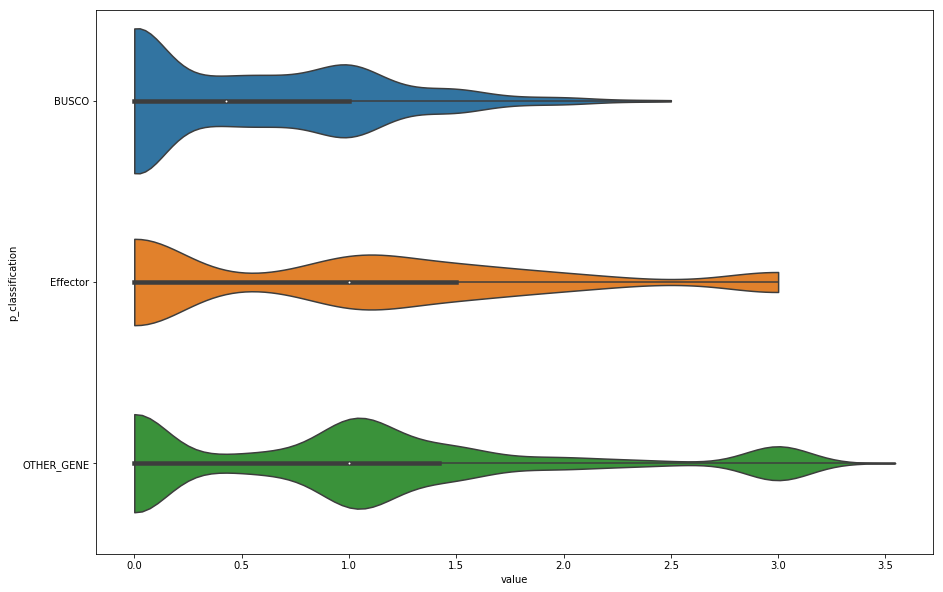

In [498]:
df = allele_hit_df.loc[:,['protein/cds_levdist', "p_classification"]].fillna(0).copy()
qdf = quant_cut_df(df.pivot(values='protein/cds_levdist', columns= 'p_classification'))

f, ax = plt.subplots(figsize=(15, 10))
df = qdf.melt()
#ax.set_xscale("log")
sns.violinplot(x='value', y="p_classification", data=df.sort_values("p_classification"), cut=0,
          whis=np.inf)
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(x='protein/cds_levdist', y="p_classification", data=df,
              #size=2, color=".3", linewidth=0)

[]

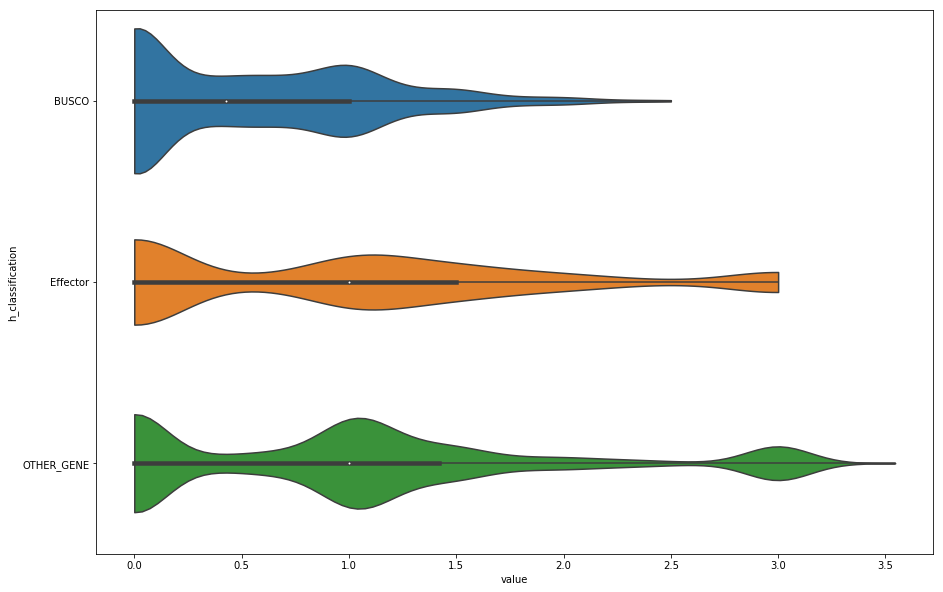

In [500]:
df = allele_hit_df.loc[:,['protein/cds_levdist', "h_classification"]].fillna(0).copy()
qdf = quant_cut_df(df.pivot(values='protein/cds_levdist', columns= 'h_classification'))

f, ax = plt.subplots(figsize=(15, 10))
df = qdf.melt()
#ax.set_xscale("log")
sns.violinplot(x='value', y="h_classification", data=df.sort_values("h_classification"), cut=0,
          whis=np.inf)
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(x='protein/cds_levdist', y="p_classification", data=df,
              #size=2, color=".3", linewidth=0)

[]

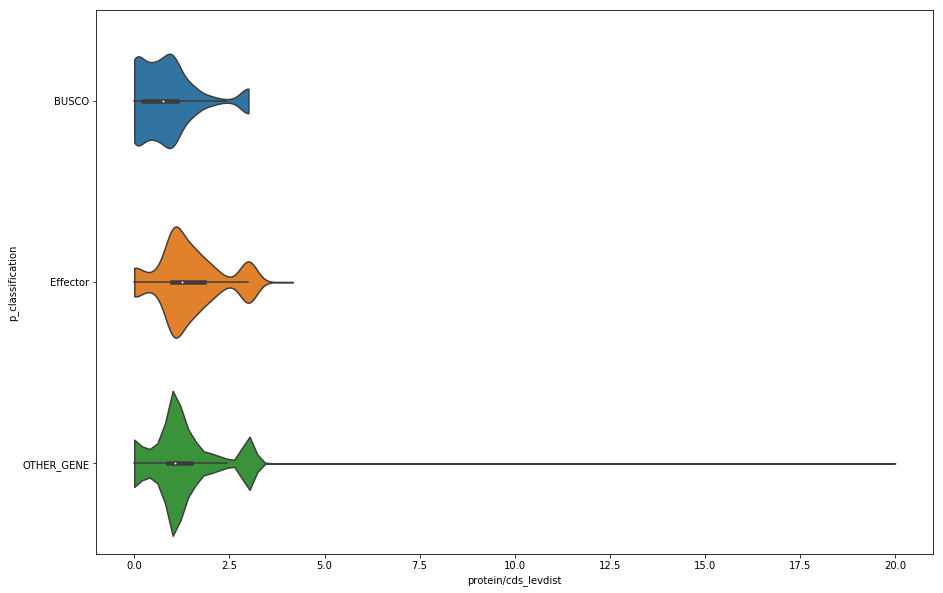

In [496]:
f, ax = plt.subplots(figsize=(15, 10))
df = allele_hit_df.loc[:,['protein/cds_levdist', "p_classification"]].copy()
#ax.set_xscale("log")
sns.violinplot(x='protein/cds_levdist', y="p_classification", data=df.sort_values("p_classification"), cut=0,
          whis=np.inf)
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(x='protein/cds_levdist', y="p_classification", data=df,
              #size=2, color=".3", linewidth=0)

[]

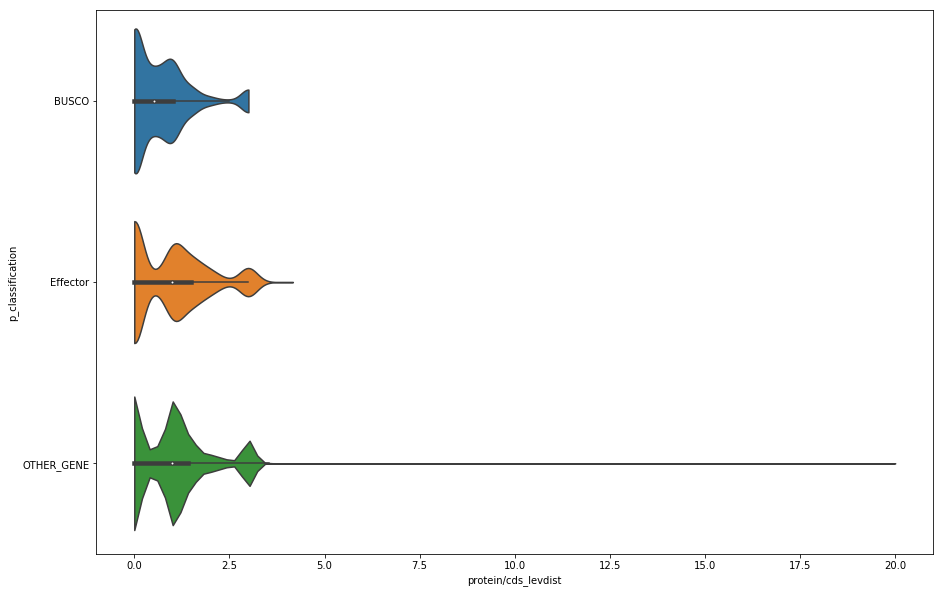

In [497]:
f, ax = plt.subplots(figsize=(15, 10))
df = allele_hit_df.loc[:,['protein/cds_levdist', "p_classification"]].fillna(0).copy()
#ax.set_xscale("log")
sns.violinplot(x='protein/cds_levdist', y="p_classification", data=df.sort_values("p_classification"), cut=0,
          whis=np.inf)
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(x='protein/cds_levdist', y="p_classification", data=df,
              #size=2, color=".3", linewidth=0)

[]

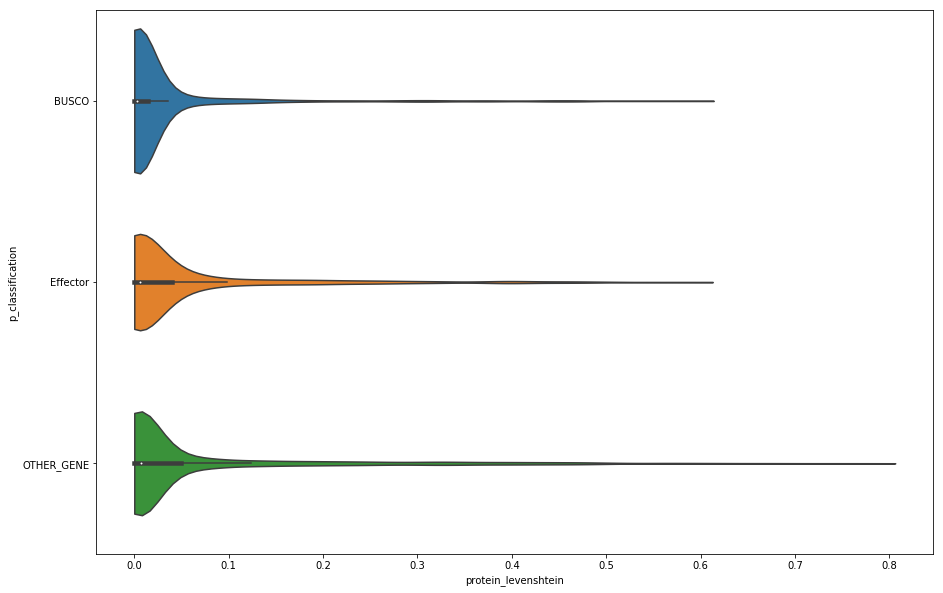

In [495]:
f, ax = plt.subplots(figsize=(15, 10))
df = allele_hit_df.loc[:,['protein_levenshtein', "p_classification"]].fillna(0).copy()
#ax.set_xscale("log")
sns.violinplot(x='protein_levenshtein', y="p_classification", data=df.sort_values("p_classification"), cut=0,
          whis=np.inf)
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(x='protein/cds_levdist', y="p_classification", data=df,
              #size=2, color=".3", linewidth=0)

[]

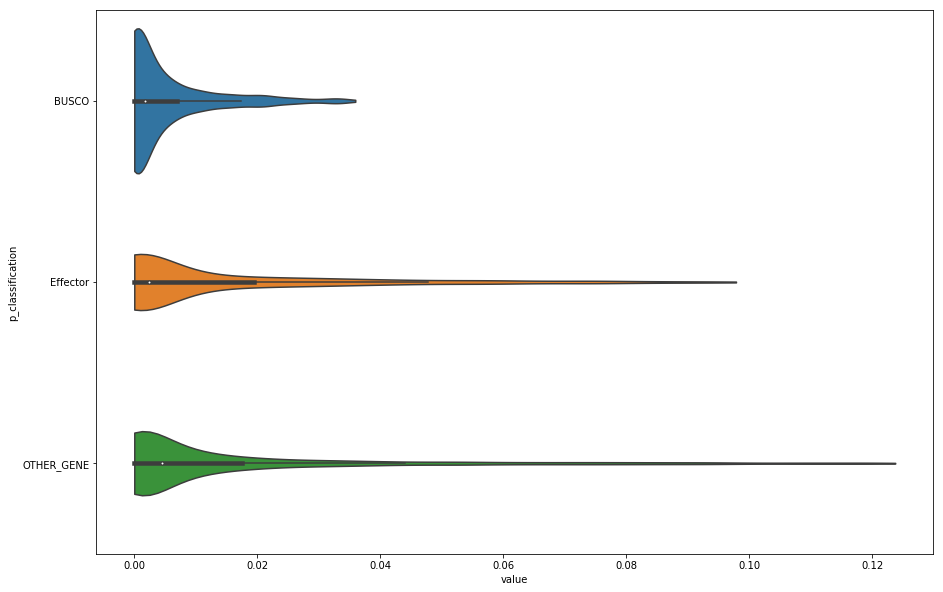

In [490]:
df = allele_hit_df.loc[:,['protein_levenshtein', "p_classification"]].copy()
qdf = quant_cut_df(df.pivot(values='protein_levenshtein', columns= 'p_classification'))

f, ax = plt.subplots(figsize=(15, 10))
df = qdf.melt()
#ax.set_xscale("log")
sns.violinplot(x='value', y="p_classification", data=df, cut=0,
          whis=np.inf)
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(x='value', y="p_classification", data=df,size=2, color=".3", linewidth=0)

[]

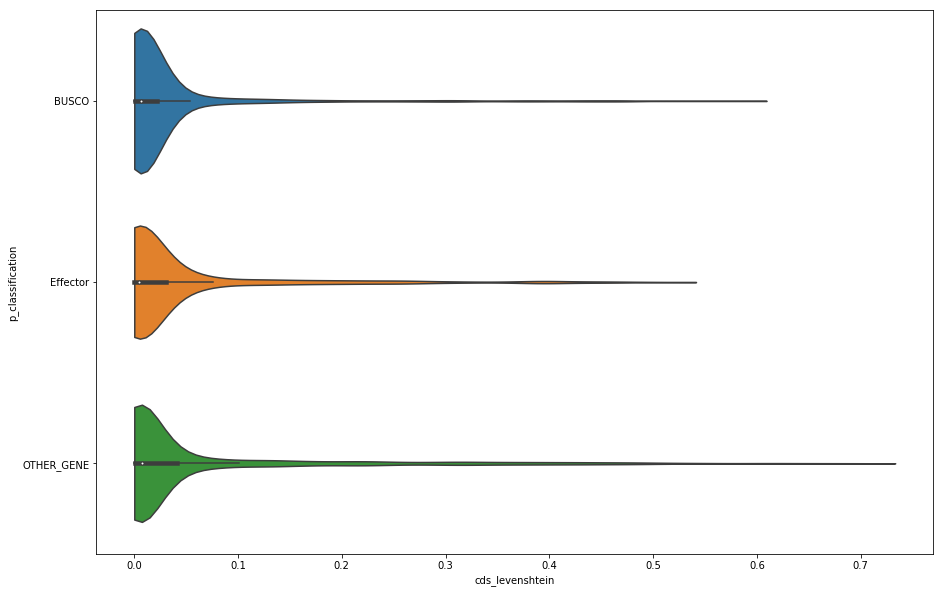

In [494]:
f, ax = plt.subplots(figsize=(15, 10))
df = allele_hit_df.loc[:,['cds_levenshtein', "p_classification"]].fillna(0).copy()
#ax.set_xscale("log")
sns.violinplot(x='cds_levenshtein', y="p_classification", data=df.sort_values("p_classification"), cut=0,
          whis=np.inf)
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(x='protein/cds_levdist', y="p_classification", data=df,
              #size=2, color=".3", linewidth=0)

[]

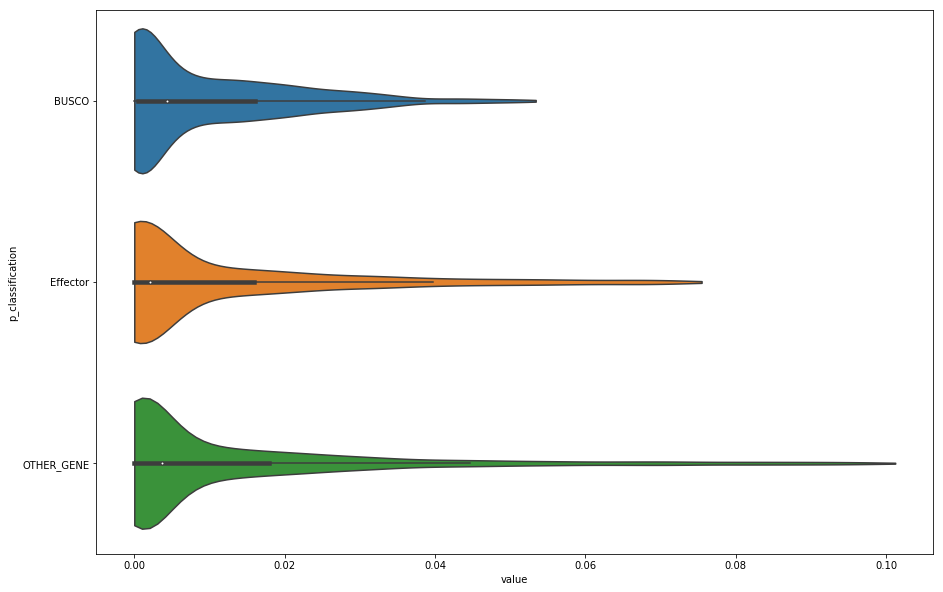

In [493]:
df = allele_hit_df.loc[:,['cds_levenshtein', "p_classification"]].copy()
qdf = quant_cut_df(df.pivot(values='cds_levenshtein', columns= 'p_classification'))

f, ax = plt.subplots(figsize=(15, 10))
df = qdf.melt()
#ax.set_xscale("log")
sns.violinplot(x='value', y="p_classification", data=df.sort_values("p_classification"), cut=0,
          whis=np.inf)
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(x='protein/cds_levdist', y="p_classification", data=df,
              #size=2, color=".3", linewidth=0)

In [434]:
allele_hit_df.head()

,Query,Target,PctID,AlnLgth,NumMis,NumGap,StartQuery,StopQuery,StartTarget,StopTarget,...,LPB93_dN/dS,P_EFFECTOR,P_BUSCO,H_EFFECTOR,H_BUSCO,H_OTHER_GENE,P_OTHER_GENE,protein/cds_levdist,p_classification,h_classification
0,evm.model.pcontig_000.100,evm.model.hcontig_000_003.107,99.21,1141.0,9.0,0.0,1.0,1141.0,1.0,1141.0,...,0.465347,False,False,False,False,True,True,1.129870,OTHER_GENE,OTHER_GENE
1,evm.model.pcontig_000.101,evm.model.hcontig_000_003.108,89.03,237.0,20.0,1.0,1.0,231.0,1.0,237.0,...,0.894180,False,False,False,False,True,True,1.560000,OTHER_GENE,OTHER_GENE
2,evm.model.pcontig_000.102,evm.model.hcontig_000_003.109,100.00,107.0,0.0,0.0,1.0,107.0,1.0,107.0,...,NaN,False,False,False,False,True,True,NaN,OTHER_GENE,OTHER_GENE
3,evm.model.pcontig_000.103,evm.model.hcontig_000_003.110,97.73,88.0,2.0,0.0,8.0,95.0,1.0,88.0,...,NaN,False,False,False,False,True,True,1.173913,OTHER_GENE,OTHER_GENE
4,evm.model.pcontig_000.104,evm.model.hcontig_000_003.111,98.53,68.0,1.0,0.0,1.0,68.0,1.0,68.0,...,NaN,False,False,False,False,True,True,3.000000,OTHER_GENE,OTHER_GENE


In [387]:
stats.ranksums(allele_df[allele_df.p_gene.isin(p_gene_dict['EFFECTORS'])]['cds_levenshtein'].tolist()\
               ,allele_df[allele_df.p_gene.isin(p_gene_dict['BUSCOS'])]['cds_levenshtein'].tolist())

RanksumsResult(statistic=-1.9831977958239608, pvalue=0.047345340018046141)

Below is the interesting observation that even the cds distances are similar between effectors and BUSCOS and the protein distance are much bigger.
Is there a difference between the protein/cds of effectors and others?

In [347]:
e_cp_ration = allele_df[allele_df.p_gene.isin(p_gene_dict['EFFECTORS'])]['protein_levenshtein']/\
allele_df[allele_df.p_gene.isin(p_gene_dict['EFFECTORS'])]['cds_levenshtein']

In [348]:
b_cp_ration = allele_df[allele_df.p_gene.isin(p_gene_dict['BUSCOS'])]['protein_levenshtein']/\
    allele_df[allele_df.p_gene.isin(p_gene_dict['BUSCOS'])]['cds_levenshtein']

In [423]:
else_cp_ration = allele_df[~(allele_df.p_gene.isin(p_gene_dict['EFFECTORS'])|\
            allele_df.p_gene.isin(p_gene_dict['BUSCOS']))]['protein_levenshtein']/\
    allele_df[~(allele_df.p_gene.isin(p_gene_dict['EFFECTORS'])|\
                allele_df.p_gene.isin(p_gene_dict['BUSCOS']))]['cds_levenshtein']

Yes the ratios of protein variation over cds variation is an unequal distribution.

In [424]:
stats.mstats.kruskalwallis(e_cp_ration.values, b_cp_ration.values,else_cp_ration.values)

KruskalResult(statistic=335.77423228618034, pvalue=1.2233532396692331e-73)

In [504]:
print(allele_hit_df[allele_hit_df.P_OTHER_GENE == True]['protein/cds_levdist'].count()\
      /len(allele_hit_df[allele_hit_df.P_OTHER_GENE == True])*100)
allele_hit_df[allele_hit_df.P_OTHER_GENE == True]['protein/cds_levdist'].describe()

78.9516982019


count    6718.000000
mean        1.287445
std         0.909530
min         0.000000
25%         0.874090
50%         1.078278
75%         1.500000
max        20.000000
Name: protein/cds_levdist, dtype: float64

In [503]:
print(allele_hit_df[allele_hit_df.P_EFFECTOR == True]['protein/cds_levdist'].count()\
      /len(allele_hit_df[allele_hit_df.P_EFFECTOR == True])*100)
allele_hit_df[allele_hit_df.P_EFFECTOR == True]['protein/cds_levdist'].describe()

65.9802306425


count    801.000000
mean       1.429452
std        0.839001
min        0.000000
25%        1.000000
50%        1.242537
75%        1.821429
max        4.166667
Name: protein/cds_levdist, dtype: float64

In [505]:
print(allele_hit_df[allele_hit_df.P_BUSCO == True]['protein/cds_levdist'].count()\
      /len(allele_hit_df[allele_hit_df.P_BUSCO == True])*100)
allele_hit_df[allele_hit_df.P_BUSCO == True]['protein/cds_levdist'].describe()

80.9682804674


count    970.000000
mean       0.871722
std        0.819080
min        0.000000
25%        0.230769
50%        0.750000
75%        1.122713
max        3.000000
Name: protein/cds_levdist, dtype: float64

In [293]:
allele_df[allele_df.p_gene.isin(p_gene_dict['EFFECTORS'])]['cds_levenshtein'].mean()

0.04068398168371404

In [294]:
allele_df[allele_df.p_gene.isin(p_gene_dict['BUSCOS'])]['cds_levenshtein'].mean()

0.028763144144375755

In [297]:
allele_df[allele_df.p_gene.isin(p_gene_dict['EFFECTORS'])]['protein_levenshtein'].mean()

0.05912425136643261

In [301]:
allele_df[allele_df.p_gene.isin(p_gene_dict['BUSCOS'])]['protein_levenshtein'].mean()

0.026462810242390274

In [300]:
allele_df[~(allele_df.p_gene.isin(p_gene_dict['EFFECTORS'])|\
            allele_df.p_gene.isin(p_gene_dict['BUSCOS']))]['cds_levenshtein'].mean()

0.057879375674427296

In [299]:
allele_df[~(allele_df.p_gene.isin(p_gene_dict['EFFECTORS'])|\
            allele_df.p_gene.isin(p_gene_dict['BUSCOS']))]['protein_levenshtein'].mean()

0.06372272433230429

In [555]:
e_to_b_closest_df = feature_bed_dict['effector'].closest(feature_bed_dict['busco']\
                                    ,d=True,t='last', io=True).to_dataframe().iloc[:,[3,9,12]]
new_header = ['Effector', 'Busco', 'distance']
e_to_b_closest_df.rename(columns=dict(zip(e_to_b_closest_df.columns, new_header)), inplace=True)

e_to_b_closest_df = e_to_b_closest_df[e_to_b_closest_df.Busco != '.']

#now add the classification for each effector
e_to_b_closest_df['classification'] = "None"
singleton_array = e_to_b_closest_df.Effector.str.replace('TU','model').isin(loose_singeltons)
e_to_b_closest_df.loc[e_to_b_closest_df[singleton_array].index,'classification' ] = "Singleton"
no_allele_ortho_array = e_to_b_closest_df.Effector.str\
    .replace('TU','model').isin(no_allele_orthologs)
e_to_b_closest_df.loc[e_to_b_closest_df[no_allele_ortho_array].index,'classification' ] = "No_allele_orthologs"
allele_array = e_to_b_closest_df.Effector.str\
    .replace('TU','model').isin(allele_hit_df.Query.unique())
e_to_b_closest_df.loc[e_to_b_closest_df[allele_array].index,'classification' ] = "Allele"

/home/benjamin/anaconda3/lib/python3.5/site-packages/pybedtools/bedtool.py:3287: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


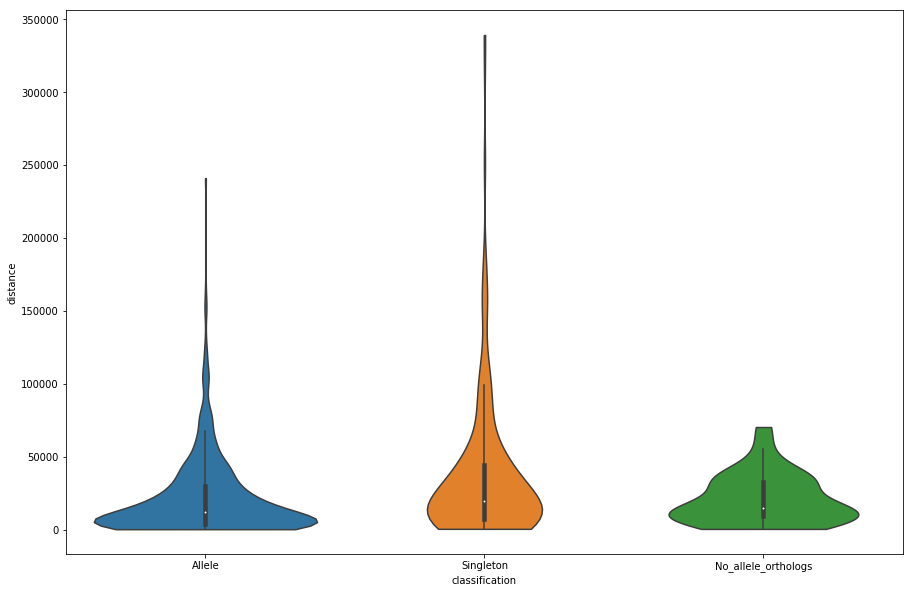

In [529]:
f, ax = plt.subplots(figsize=(15, 10))
sns.violinplot(x='classification', y='distance', data =e_to_b_closest_df, cut=0)

In [565]:
x_test = e_to_b_closest_df[e_to_b_closest_df.classification == 'Singleton']['distance'].values
y_test = e_to_b_closest_df[e_to_b_closest_df.classification == "Allele"]['distance'].values
stats.stats.ranksums(x_test, y_test)

RanksumsResult(statistic=5.4237505001583406, pvalue=5.8361329699453958e-08)

In [530]:
e_to_b_closest_df.groupby('classification')['distance'].describe()

,count,mean,std,min,25%,50%,75%,max
classification,,,,,,,,
Allele,1193.0,21967.022632,27147.817705,281.0,4035.00,12384.0,29960.00,241042.0
No_allele_orthologs,28.0,20863.607143,17239.819754,468.0,9199.25,14560.5,32927.25,70337.0
Singleton,338.0,36508.355030,49446.013725,525.0,7259.25,19859.0,44444.75,339166.0


In [531]:
e_allele_to_b_closest_df = e_to_b_closest_df[e_to_b_closest_df.classification == 'Allele'].copy()

In [536]:
e_allele_to_b_closest_df['Query'] = e_allele_to_b_closest_df.Effector.apply(lambda x:
                                                                           x.replace('TU','model'))

e_allele_to_b_closest_df = pd.merge(e_allele_to_b_closest_df,allele_hit_df.loc[:,\
            ['Query', 'codmel_dN/dS', 'protein_hamming',
       'cds_hamming', 'protein_levenshtein', 'cds_levenshtein', 'vn00_dN/dS',
       'LWL85_dN/dS', 'LWL85m_dN/dS', 'LPB93_dN/dS', 'protein/cds_levdist']], on='Query')

In [546]:
e_allele_to_b_closest_df.head()

,Effector,Busco,distance,classification,Query,codmel_dN/dS,protein_hamming,cds_hamming,protein_levenshtein,cds_levenshtein,vn00_dN/dS,LWL85_dN/dS,LWL85m_dN/dS,LPB93_dN/dS,protein/cds_levdist
0,evm.TU.pcontig_000.3,evm.TU.pcontig_000.11,31275,Allele,evm.model.pcontig_000.3,0.1362,0.016878,0.022504,0.016878,0.022504,0.128039,0.137574,0.210421,0.182731,0.750000
1,evm.TU.pcontig_000.6,evm.TU.pcontig_000.11,10972,Allele,evm.model.pcontig_000.6,0.7488,0.050998,0.050259,0.050998,0.049520,0.581818,0.284091,0.574074,0.574074,1.029851
2,evm.TU.pcontig_000.9,evm.TU.pcontig_000.11,5827,Allele,evm.model.pcontig_000.9,0.4706,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
3,evm.TU.pcontig_000.9,evm.TU.pcontig_000.11,5827,Allele,evm.model.pcontig_000.9,0.4823,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
4,evm.TU.pcontig_000.14,evm.TU.pcontig_000.11,6542,Allele,evm.model.pcontig_000.14,98.9998,0.002457,0.000819,0.002457,0.000819,NaN,NaN,NaN,NaN,3.000000


SpearmanrResult(correlation=0.052623741500588461, pvalue=masked_array(data = 0.1917564874532692,
             mask = False,
       fill_value = 1e+20)
)


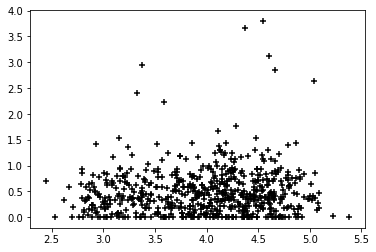

In [572]:
x_now = np.log10(e_allele_to_b_closest_df.distance)
y_now=e_allele_to_b_closest_df['vn00_dN/dS']
plt.scatter(x=x_now,y=y_now, marker ='+', color='k')
print(stats.stats.spearmanr(x_now, y_now,nan_policy='omit'))

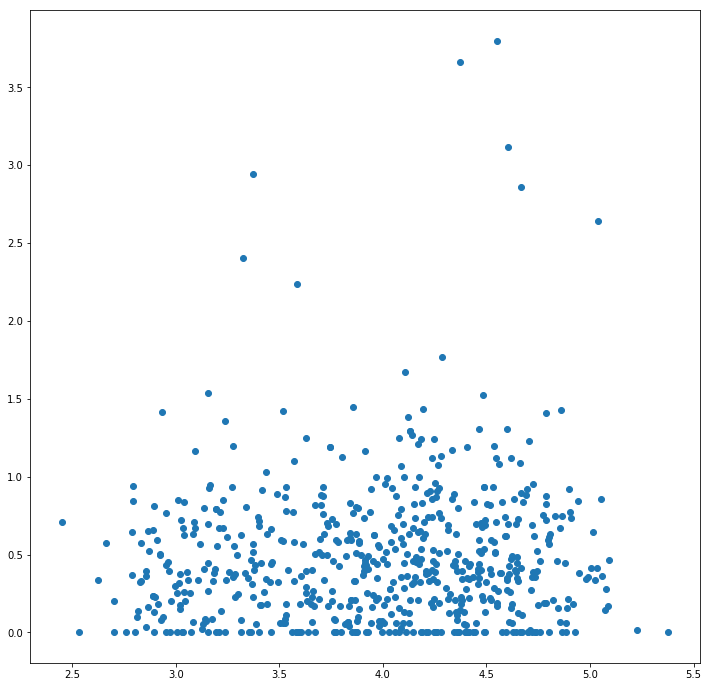

In [571]:
fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(x=np.log10(e_allele_to_b_closest_df.distance), y=e_allele_to_b_closest_df['vn00_dN/dS'] )

In [562]:
#make a closest_df with classificaiton and allelic variation
e_to_g_closest_df = feature_bed_dict['effector'].closest(feature_bed_dict['genes']\
                                    ,d=True,t='last', io=True).to_dataframe().iloc[:,[3,9,12]]
new_header = ['Effector', 'gene', 'distance']
e_to_g_closest_df.rename(columns=dict(zip(e_to_g_closest_df.columns, new_header)), inplace=True)

e_to_g_closest_df = e_to_g_closest_df[e_to_g_closest_df.gene != '.']

#now add the classification for each effector
e_to_g_closest_df['classification'] = "None"
singleton_array = e_to_g_closest_df.Effector.str.replace('TU','model').isin(loose_singeltons)
e_to_g_closest_df.loc[e_to_g_closest_df[singleton_array].index,'classification' ] = "Singleton"
no_allele_ortho_array = e_to_g_closest_df.Effector.str\
    .replace('TU','model').isin(no_allele_orthologs)
e_to_g_closest_df.loc[e_to_g_closest_df[no_allele_ortho_array].index,'classification' ] = "No_allele_orthologs"
allele_array = e_to_g_closest_df.Effector.str\
    .replace('TU','model').isin(allele_hit_df.Query.unique())
e_to_g_closest_df.loc[e_to_g_closest_df[allele_array].index,'classification' ] = "Allele"

#now for alleles
e_allele_to_g_closest_df = e_to_g_closest_df[e_to_g_closest_df.classification == 'Allele'].copy()
e_allele_to_g_closest_df['Query'] = e_allele_to_g_closest_df.Effector.apply(lambda x:
                                                                           x.replace('TU','model'))

e_allele_to_g_closest_df = pd.merge(e_allele_to_g_closest_df,allele_hit_df.loc[:,\
            ['Query', 'codmel_dN/dS', 'protein_hamming',
       'cds_hamming', 'protein_levenshtein', 'cds_levenshtein', 'vn00_dN/dS',
       'LWL85_dN/dS', 'LWL85m_dN/dS', 'LPB93_dN/dS', 'protein/cds_levdist']], on='Query')

/home/benjamin/anaconda3/lib/python3.5/site-packages/pybedtools/bedtool.py:3287: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


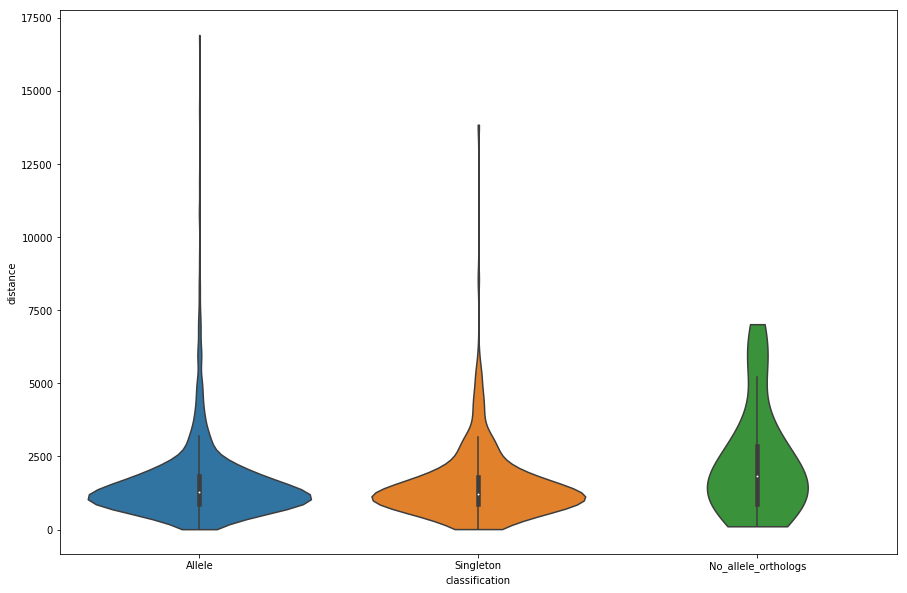

In [563]:
f, ax = plt.subplots(figsize=(15, 10))
sns.violinplot(x='classification', y='distance', data =e_to_g_closest_df, cut=0)

In [567]:
x_test = e_to_g_closest_df[e_to_g_closest_df.classification == 'Singleton']['distance'].values
y_test = e_to_g_closest_df[e_to_g_closest_df.classification == "Allele"]['distance'].values
stats.stats.ranksums(x_test, y_test)

RanksumsResult(statistic=-0.6386686050070971, pvalue=0.52303854055023435)

SpearmanrResult(correlation=-0.071721269289919662, pvalue=0.012433579621677892)


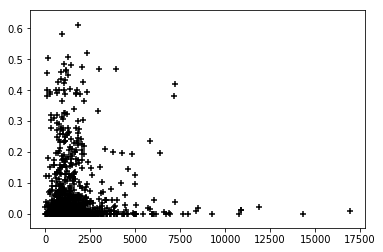

In [570]:
x_now = e_allele_to_g_closest_df.distance
y_now=e_allele_to_g_closest_df['protein_levenshtein']
plt.scatter(x=x_now,y=y_now, marker ='+', color='k')
print(stats.stats.spearmanr(x_now, y_now,nan_policy='omit'))

In [506]:
feature_bed_dict.keys()

dict_keys(['no_busco', 'genes', 'effector', 'TE_g1000', 'haustoria', 'no_be', 'no_effector', 'TE_g400', 'busco'])

In [508]:
feature_bed_dict['effector'].closest(feature_bed_dict['busco'],d=True,t='last', io=True).to_dataframe()

/home/benjamin/anaconda3/lib/python3.5/site-packages/pybedtools/bedtool.py:3287: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,pcontig_000,8490,9492,evm.TU.pcontig_000.3,.,+,pcontig_000,40766,43007,evm.TU.pcontig_000.11,.,+,31275
1,pcontig_000,28352,29795,evm.TU.pcontig_000.6,.,+,pcontig_000,40766,43007,evm.TU.pcontig_000.11,.,+,10972
2,pcontig_000,34649,34940,evm.TU.pcontig_000.9,.,-,pcontig_000,40766,43007,evm.TU.pcontig_000.11,.,+,5827
3,pcontig_000,49548,50911,evm.TU.pcontig_000.14,.,+,pcontig_000,40766,43007,evm.TU.pcontig_000.11,.,+,6542
4,pcontig_000,66837,67400,evm.TU.pcontig_000.19,.,-,pcontig_000,60473,65016,evm.TU.pcontig_000.18,.,+,1822
5,pcontig_000,227999,228495,evm.TU.pcontig_000.63,.,+,pcontig_000,310510,311517,evm.TU.pcontig_000.78,.,+,82016
6,pcontig_000,338223,339410,evm.TU.pcontig_000.85,.,+,pcontig_000,340207,342829,evm.TU.pcontig_000.86,.,-,798
7,pcontig_000,439981,440863,evm.TU.pcontig_000.112,.,-,pcontig_000,465766,466967,evm.TU.pcontig_000.119,.,+,24904
8,pcontig_000,686455,687551,evm.TU.pcontig_000.174,.,-,pcontig_000,701548,702781,evm.TU.pcontig_000.178,.,+,13998
9,pcontig_000,718079,719522,evm.TU.pcontig_000.182,.,-,pcontig_000,701548,702781,evm.TU.pcontig_000.178,.,+,15299


Now pick a couple of the non_respective_haplotype alignements and get sequencing data for those to make a plot

In [ ]:
no_respective_alleles_fn = os.path.join(ALLELE_PATH, 'Pst_104E_v12_p_ctg.no_respective_h_contig_overlap.alleles')
contig_fa_fn = os.path.join(BASE_A_PATH, 'Pst_104E_v12_ph_ctg.fa')
gene_fa_fn = os.path.join(BASE_A_PATH, 'Pst_104E_v12_ph_ctg.anno.gene.fa')
OUT_PATH_NO_RES = os.path.join(OUT_PATH, 'no_respect_fasta')
if not os.path.exists(OUT_PATH_NO_RES):
    os.mkdir(OUT_PATH_NO_RES)

In [ ]:
no_respective_alleles_df = pd.read_csv(no_respective_alleles_fn, sep='\t', header=None, names=['pgene', 'hgene'])

In [ ]:
#get the contig genes are on
no_respective_alleles_df['pcontig'] = no_respective_alleles_df.pgene.str.extract(r'(p[^.]*)')
no_respective_alleles_df['hcontig'] = no_respective_alleles_df.hgene.str.extract(r'(h[^.]*)')

In [ ]:
#prepare for filtering on most hit contigs. First by a group by function
no_ra_linkage_count_df = no_respective_alleles_df.groupby(['pcontig','hcontig'])['pgene'].count()
no_ra_linkage_count_max = no_respective_alleles_df.groupby(['pcontig','hcontig'])['pgene']\
            .count().max(level=0)

In [ ]:
no_ra_linkage_count_df = no_ra_linkage_count_df.unstack()

In [ ]:
p_contig_list = []
most_linked_hcontig = []
number_of_hits = []
for _index, row in no_ra_linkage_count_df.iterrows():
    if row.max() > 2:
        p_contig_list.append(_index)
        most_linked_hcontig.append(row[row==no_ra_linkage_count_max[_index]].index.tolist()[0])
        number_of_hits.append(row[row==no_ra_linkage_count_max[_index]].max())
        #print('primary contig %s and %s overlaps %i' %\
              #(_index, row[row==no_ra_linkage_count_max[_index]].index.tolist()[0],row[row==no_ra_linkage_count_max[_index]].max() ))

In [ ]:
most_linked_non_ra_alleles_df = pd.concat([pd.Series(p_contig_list)\
                            , pd.Series(most_linked_hcontig), pd.Series(number_of_hits)], axis=1)

In [ ]:
most_linked_non_ra_alleles_df.rename(columns={0:'pcontig', 1:'hcontig', 2:'number_of_overlaps'}, inplace=True)

In [ ]:
#now loop over the best hit dataframe to get all the fasta sequences of the repective alleles

for _index, row in most_linked_non_ra_alleles_df.iterrows():
    tmp_p_contig = row['pcontig']
    tmp_h_contig = row['hcontig']
    h_genes = no_respective_alleles_df[(no_respective_alleles_df.pcontig==tmp_p_contig)&\
                                      (no_respective_alleles_df.hcontig==tmp_h_contig)]\
                                        ['hgene'].unique()
    p_genes = no_respective_alleles_df[(no_respective_alleles_df.pcontig==tmp_p_contig)&\
                                      (no_respective_alleles_df.hcontig==tmp_h_contig)]\
                                        ['pgene'].unique()
    #get the h_gene and p_gene sequenes
    h_gene_seq = return_gene_fasta(h_genes, gene_fa_fn)
    p_gene_seq = return_gene_fasta(p_genes, gene_fa_fn)
    with open(os.path.join(OUT_PATH_NO_RES, 'no_res_allele_%s_pgene.fa' %tmp_p_contig), 'w') as fh:
        SeqIO.write(p_gene_seq, fh, 'fasta')
    with open(os.path.join(OUT_PATH_NO_RES, 'no_res_allele_%s_hgene.fa' %tmp_p_contig), 'w') as fh:
        SeqIO.write(h_gene_seq, fh, 'fasta')
    #get the contig sequences
    p_contig_seq = return_contig_fasta([tmp_p_contig], contig_fa_fn)
    h_contig_seq = return_contig_fasta([tmp_h_contig], contig_fa_fn)
    with open(os.path.join(OUT_PATH_NO_RES, 'no_res_allele_%s_pcontig.fa' %tmp_p_contig), 'w') as fh:
        SeqIO.write(p_contig_seq, fh, 'fasta')
    with open(os.path.join(OUT_PATH_NO_RES, 'no_res_allele_%s_hcontig.fa' %tmp_p_contig), 'w') as fh:
        SeqIO.write(h_contig_seq, fh, 'fasta')

    
    

In [ ]:
#add quick mummerplots
os.chdir(OUT_PATH_NO_RES)
for _index, row in most_linked_non_ra_alleles_df.iterrows():
    tmp_p_contig = row['pcontig']
    tmp_h_contig = row['hcontig']
    ref = os.path.join(OUT_PATH_NO_RES, 'no_res_allele_%s_pcontig.fa' %tmp_p_contig)
    query = os.path.join(OUT_PATH_NO_RES, 'no_res_allele_%s_hcontig.fa' %tmp_p_contig)
    nucmer = '/home/benjamin/anaconda3/bin/nucmer'
    !nucmer --maxgap=500 --mincluster=100 --prefix={ref[:-3]} {ref} {query}
    !show-coords -r {ref[:-3]}.delta > {ref[:-3]}.coords
    !delta-filter -q -r {ref[:-3]}.delta > {ref[:-3]}.filter
    !perl /home/benjamin/anaconda3/bin/mummerplot --postscript {ref[:-3]}.filter -R {ref} -Q {query} --prefix={ref[:-3]}

In [ ]:
!which nucmer

In [ ]:
most_linked_non_ra_alleles_df.sort_values('number_of_overlaps', inplace=True)
most_linked_non_ra_alleles_df.to_csv(os.path.join(OUT_PATH_NO_RES, 'max_linkage_per_pcontig.tab'), sep='\t')

In [ ]:
#check out the lenght of those contigs
c_list = return_contig_fasta(most_linked_non_ra_alleles_df.pcontig.unique(), contig_fa_fn)

In [ ]:
c_len_list = [len(x.seq) for x in c_list]
all_len_list = [len(x.seq) for x in return_contig_fasta(allele_blast_df.q_contig.unique(), contig_fa_fn)]

In [ ]:
stats.ranksums(c_len_list, all_len_list)

In [ ]:
#mean and median of contigs with 2> linkages to another haplotig
print(np.mean(c_len_list),np.median(c_len_list))

In [ ]:
#mean and median of contigs with 2> linkages to another haplotig
print(np.mean(all_len_list),np.median(all_len_list))

In [ ]:
most_linked_non_ra_alleles_df.number_of_overlaps.sum()

In [ ]:
no_ra_linkage_count_df.sum(axis=1).index

In [ ]:
no_ra_linkage_count_df.sum(axis=1)/\
[len(x.seq) for x in return_contig_fasta(no_ra_linkage_count_df.sum(axis=1).index, contig_fa_fn)]

In [ ]:
!ls {BASE_A_PATH}

In [ ]:
len(tmp_df_ids)

In [ ]:
tmp_df.QCov

In [ ]:
QP_filter = (allele_QC_df.QCov >= QCov_limit) & (allele_QC_df.PctID >= PctID_limit)

In [ ]:
#now a bit more specific for each haplotyp
os.chdir(ALLELE_QC_PATH)
allele_blast_df.head()